<center>
  <h1 style="background-color: #80dfffff; color: #137a91ff; padding: 10px">
    <strong>Deliverable 1</strong>
  </h1>
</center>

**Student ID's:**

Andreea Roica: 20250361

Beatriz Varela: 20250367

Barbara Franco: 20250388

Marisa Esteves: 20250348

<h2 style="background-color: #80dfffff; color: #137a91ff; padding: 5px; margin: 5px;">
<strong>Index</strong>
</h2>

[1. **Business Understanding**](#1st-bullet)<br>

[2. **Data Understanding**](#2nd-bullet)<br>
- [2.1 Metadata, Importing Libraries and Dataset](#3rd-bullet)<br>
- [2.2 Data Exploration](#4th-bullet)<br>
- [2.3 Data Preparation](#5th-bullet)<br>

[3. **Modeling**](#6th-bullet)<br>

[4. **Deployment**](#7th-bullet)<br>
    

We will follow the CRISP-DM methodology.

<h2 id="1st-bullet" style="background-color: #f7d888ff; color: #da6919ff; padding: 5px; margin: 5px;">
  <strong>  1. Business Understanding</strong>
</h2>


The goal of this project is to create a regression model that can predict car prices based on its details. This includes:

- Regression Benchmarking
- Model Optimization
- Additional Insights

<h2 id="2nd-bullet" style="background-color: #f7d888ff; color: #da6919ff; padding: 5px; margin: 5px;">
  <strong> 2. Data Understanding</strong>
</h2>


<h3 id="3rd-bullet" style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> 2.1 Metadata, Importing Libraries and Dataset</strong>
</h3>



- **carID** : An attribute that contains an identifier for each car.
- **Brand** : The car’s main brand (e.g. Ford, Toyota).
- **model** : The car model.
- **year**: The year of Registration of the Car.
- **transmission** - Type of transmission of the car (e.g. Manual, Automatic, Semi-Automatic)
- **mileage** : The total reported distance travelled by the car (in miles).
- **tax** : The amount of road tax (in £) that, in 2020, was applicable to the car in question.
- **fuelType** : Type of Fuel used by the car (Diesel, Petrol, Hybrid, Electric).
- **mpg** : Average Miles per Gallon.
- **engineSize** : Size of Engine in liters (Cubic Decimeters).
- **paintQuality%** : The mechanic’s assessment of the cars’ overall paint quality and hull integrity (filled by the mechanic during evaluation).
- **previousOwners** : Number of previous registered owners of the vehicle.
- **hasDamage** : Boolean marker filled by the seller at the time of registration stating whether the car is damaged or not.
- **price** : The car’s price when purchased by Cars 4 You (in £).

- Installing fuzzywuzzy package for typo correction:

In [1]:
!pip install fuzzywuzzy

### 
- Importing necessary libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import openpyxl 
from math import ceil

# Import to divide the train set, encode and scale variables
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder, StandardScaler, OneHotEncoder

# Import models and metrics used
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, ElasticNet, HuberRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, root_mean_squared_error

# Import fuzzywuzzy to correct the typos in 'Brand', 'fuelType' snd 'transmission'
from fuzzywuzzy import fuzz

# Import get_close_matches to identify and group similar words for typo correction in 'model'
from difflib import get_close_matches

# Import to perform the Chi-squared test
from scipy.stats import chi2_contingency

# Import for wrapper methods
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')


- Setting a random seed:

In [3]:

np.random.seed(33)

- Reading the data:

In [4]:

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


<h3 id="4th-bullet" style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> 2.2 Data Exploration </strong>
</h3>


In [5]:
df_train.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


We can already see that we have Null Values (at least in tax) and have strange values like negative/float previous owners.

In [6]:
df_test.head()

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
1,106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
2,80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
3,100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
4,81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


Identified Problems:

- Year and previousOwners is float when it should be integer
- hasDamage should be boolean instead of float

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32567 entries, 0 to 32566
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           32567 non-null  int64  
 1   Brand           31918 non-null  object 
 2   model           31917 non-null  object 
 3   year            31914 non-null  float64
 4   transmission    31944 non-null  object 
 5   mileage         31878 non-null  float64
 6   fuelType        31911 non-null  object 
 7   tax             29259 non-null  float64
 8   mpg             29279 non-null  float64
 9   engineSize      31939 non-null  float64
 10  paintQuality%   31942 non-null  float64
 11  previousOwners  31970 non-null  float64
 12  hasDamage       31970 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 3.2+ MB



<h3 style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> Duplicates </strong>
</h3>


In [9]:
print('Check duplicates:')
print(f'Train: {df_train.duplicated().sum()}\nTest: {df_test.duplicated().sum()}')
print('\nCheck duplicates in carId:')
print(f"Train: {df_train.duplicated(subset='carID').sum()}\nTest: {df_test.duplicated(subset='carID').sum()}")

Check duplicates:
Train: 0
Test: 0

Check duplicates in carId:
Train: 0
Test: 0



<h3 style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> Missing Values </strong>
</h3>


In [10]:
round(df_train.isna().sum() / df_train.shape[0],3)

carID             0.000
Brand             0.020
model             0.020
year              0.020
price             0.000
transmission      0.020
mileage           0.019
fuelType          0.020
tax               0.104
mpg               0.104
engineSize        0.020
paintQuality%     0.020
previousOwners    0.020
hasDamage         0.020
dtype: float64

All the variables, except the target ('price'), show a large amount of missing values (~2% of missing values in each one).


<h3 style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> Categorical Variables </strong>
</h3>


In [11]:
categorical_features = ['Brand', 'model', 'transmission', 'fuelType']

In [12]:
df_train.describe(include='object')

,Brand,model,transmission,fuelType
count,74452,74456,74451,74462
unique,72,735,40,34
top,Ford,Focus,Manual,Petrol
freq,14808,6353,38050,37995


- Checking unique values:

In [13]:
for feat in categorical_features:
    print(f'{feat} :' )
    print(f'{pd.concat([df_train[feat], df_test[feat]]).unique().tolist()}\n')

Brand :
['VW', 'Toyota', 'Audi', 'Ford', 'BMW', 'Skoda', 'Opel', 'Mercedes', 'FOR', 'mercedes', 'Hyundai', 'w', 'ord', 'MW', 'bmw', nan, 'yundai', 'BM', 'Toyot', 'udi', 'Ope', 'AUDI', 'V', 'opel', 'pel', 'For', 'pe', 'Mercede', 'audi', 'MERCEDES', 'OPEL', 'koda', 'FORD', 'Hyunda', 'W', 'Aud', 'vw', 'hyundai', 'skoda', 'ford', 'TOYOTA', 'ercedes', 'oyota', 'toyota', 'SKODA', 'Skod', 'HYUNDAI', 'kod', 'v', 'for', 'SKOD', 'aud', 'KODA', 'PEL', 'yunda', 'or', 'UDI', 'OYOTA', 'HYUNDA', 'mw', 'OPE', 'mercede', 'ERCEDES', 'ercede', 'TOYOT', 'MERCEDE', 'ORD', 'ud', 'ope', 'AUD', 'hyunda', 'skod', 'toyot', 'M', 'YUNDAI', 'oyot', 'bm']

model :
[' Golf', ' Yaris', ' Q2', ' FIESTA', ' 2 Series', '3 Series', ' A3', ' Octavia', ' Passat', ' Focus', ' Insignia', ' A Clas', ' Q3', ' Fabia', ' A Class', ' Ka+', ' 3 Series', ' GLC Class', ' I30', ' C Class', ' Polo', ' E Class', ' C Clas', ' Q5', ' Up', ' Fiesta', ' C-HR', ' Mokka X', ' Corsa', ' Astra', ' TT', ' 5 Series', ' Aygo', ' 4 Series', ' SLK'

Every categorical features presents a large number of unique values which refer to the same class but are wrongly typed (e.g. 'petro' and 'PETROL' in fuelType).

### **Bar Plots**

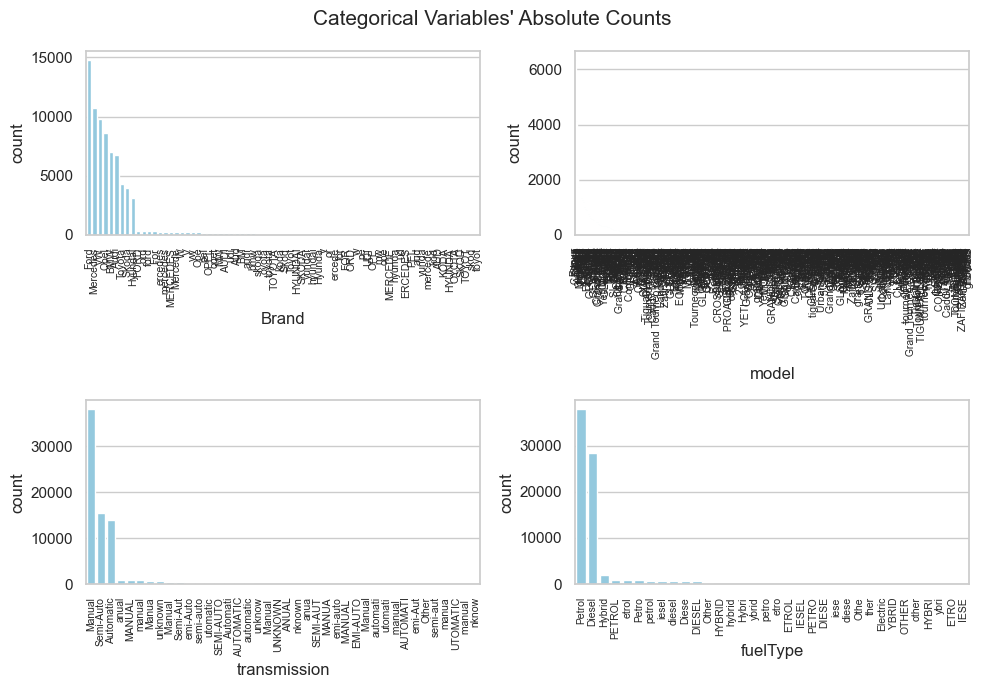

In [14]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(
    2, 
    ceil(len(categorical_features) / 2), 
    figsize=(10, 7)
    )

for ax, feat in zip(axes.flatten(), categorical_features):
    sns.countplot(x=df_train[feat], ax=ax, 
                  order=df_train[feat].value_counts().index, color = 'skyblue') 
    ax.tick_params(axis='x', rotation=90, labelsize='7.5')  


plt.suptitle("Categorical Variables' Absolute Counts", fontsize=15)

plt.tight_layout()
plt.show()

With these plots we can further visualize the problems in the categorical variables: a large amount of classes, most with very low frequency and similar names. We will fix this in Data Preparation.

### **Association between variables**

To evaluate the association between categorical (nominal) variables we will perfom the chi-squared test. 

H0: There is no evidence of a statistically significant association.

H1: There is a statistically significant association between the variables.

Interpretation:
- if p_value < 0.05 (significance level): Reject H0, so there is a statistically significant association between the {var1} and {var2}.
- if p_value >= 0.05 (significance level): Do not reject H0, so there is no evidence of a statistically significant association.

In [15]:
association_results = pd.DataFrame(columns=categorical_features, index=categorical_features)

def color_pvalues(val):

    """
    Applies color formatting to p-values for visualization in tables.

    The function returns a string that can be used with pandas 'DataFrame.style' to visually indicate statistical significance:
    - Green background if p-value < 0.05, indicating a significant association.
    - Red background if p-value >= 0.05, indicating no significant association.
    - Black text color and a black border are applied in both cases.

    Parameters
    ----------
    val : float
        The p-value to be evaluated.

    Returns
    -------
    str
        A string that can be used to style a pandas DataFrame cell.
    """

    if val < 0.05:
        return 'background-color: lightgreen; color:black; border: 1px solid black;'
    else:
        return 'background-color: lightcoral; color:black; border: 1px solid black;'

for var1 in categorical_features:
    for var2 in categorical_features:
        #Chi-square test between {var1} and {var2}

        contingency_table = pd.crosstab(df_train[var1], df_train[var2]) # Create the contingency table
        result = chi2_contingency(contingency_table) # Perform the Chi-square test
                                                    #Chi-square Statistic: result[0]
                                                    #p-value: result[1]
                                                    #Degrees of Freedom: result[2]
                                                    #Expected Frequencies: result[3]
        association_results.loc[var1, var2] = result[1]

association_results= association_results.style.map(color_pvalues)
display(association_results)

,Brand,model,transmission,fuelType
Brand,0.000000,0.000000,0.000000,0.000000
model,0.000000,0.000000,0.000000,0.000000
transmission,0.000000,0.000000,0.000000,0.000000
fuelType,0.000000,0.000000,0.000000,0.000000


To measure their association we will use Cramer's V (suitable for nominal variables).

**Cramer's V = √(X2/N) / min(C-1, R-1)**

X2- Chi- squared statistics;

N- Total number of observations;

C- Number of columns in the contingency table;

R- Number of rows in the contingency table.

In [16]:
cramer_v_table = pd.DataFrame(columns=categorical_features, index = categorical_features)

for var1 in cramer_v_table.columns:
    for var2 in cramer_v_table.index:

        contingency_table = pd.crosstab(df_train[var1], df_train[var2])
        result = chi2_contingency(contingency_table)        

        # Calculate Cramer's V
        X2 = result[0]
        n = df_train.shape[0]
        minimum_dimension = min(df_train[var1].nunique(), df_train[var2].nunique())-1
        cramer_v_table.loc[var1, var2] = np.sqrt((X2/n) / minimum_dimension)

def color_cramervalues(val):

    """
    Applies color formatting to Cramér's V values for visualization in tables.

    The function returns a string that can be used with pandas 'DataFrame.style' to visually indicate the strength of association between categorical variables:
    - Green background if Cramér's V > 0.6, indicating a strong association.
    - Red background if Cramér's V <= 0.6, indicating a weak or moderate association.
    - Black text color and a black border are applied in both cases.

    Parameters
    ----------
    val : float
        The Cramér's V value to be evaluated.

    Returns
    -------
    str
        A string that can be used to style a pandas DataFrame cell.
    """

    if val > 0.6:
        return 'background-color: lightgreen; color:black; border: 1px solid black;'
    else:
        return 'background-color: lightcoral; color:black; border: 1px solid black;'


cramer_v_table= cramer_v_table.style.map(color_cramervalues)
display(cramer_v_table)

,Brand,model,transmission,fuelType
Brand,0.989939,0.338708,0.097623,0.099330
model,0.338708,0.989966,0.140960,0.192912
transmission,0.097623,0.140960,0.989933,0.071666
fuelType,0.099330,0.192912,0.071666,0.990006


The strength of the associations is low due to the number of typos that exist. 


<h3 style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> Numerical Variables </strong>
</h3>


In [17]:
df_train = df_train.set_index ('carID')
df_test = df_test.set_index ('carID')

In [18]:
numeric_features = df_train.columns.drop(categorical_features)

In [19]:
df_train.describe()

,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,74482.000000,75973.000000,74510.000000,68069.000000,68047.000000,74457.000000,74449.000000,74423.000000,74425.0
mean,2017.096611,16881.889553,23004.184088,120.329078,55.152666,1.660136,64.590667,1.994580,0.0
std,2.208704,9736.926322,22129.788366,65.521176,16.497837,0.573462,21.021065,1.472981,0.0
min,1970.000000,450.000000,-58540.574478,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,2016.000000,10200.000000,7423.250000,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,2017.000000,14699.000000,17300.000000,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,2019.000000,20950.000000,32427.500000,145.000000,62.800000,2.000000,82.000000,3.000000,0.0
max,2024.121759,159999.000000,323000.000000,580.000000,470.800000,6.600000,125.594308,6.258371,0.0


### **Histograms**

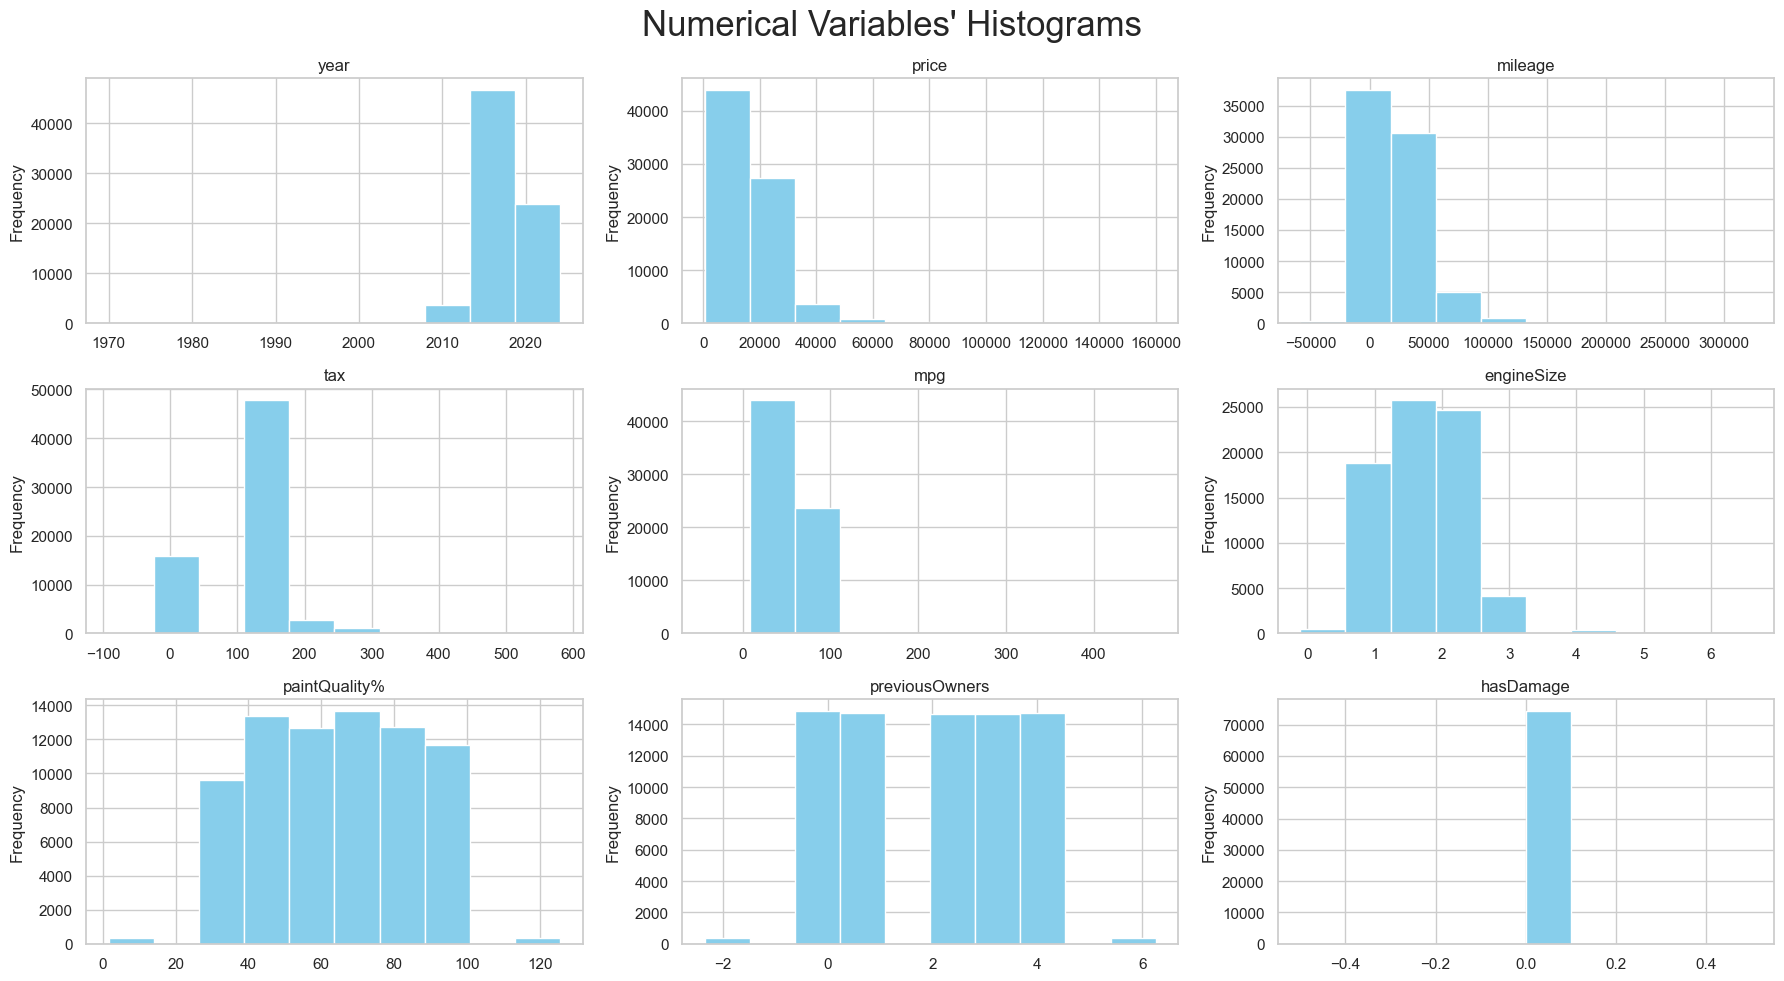

In [20]:
# We will put all the numeric variables' histograms in one figure

fig, axes = plt.subplots(ceil(len(numeric_features) / 3 ), 3, figsize=(18, 10))

for ax, feat in zip(axes.flatten(), numeric_features):
    ax.hist(df_train[feat], color = 'skyblue')
    ax.set_title(feat)
    ax.set_ylabel('Frequency')

# Delete empty plots
for ax in axes.flatten()[len(numeric_features):]:
    ax.axis('off')  


plt.suptitle("Numerical Variables' Histograms", fontsize=25)

plt.tight_layout()
plt.show()

### **Boxplots**

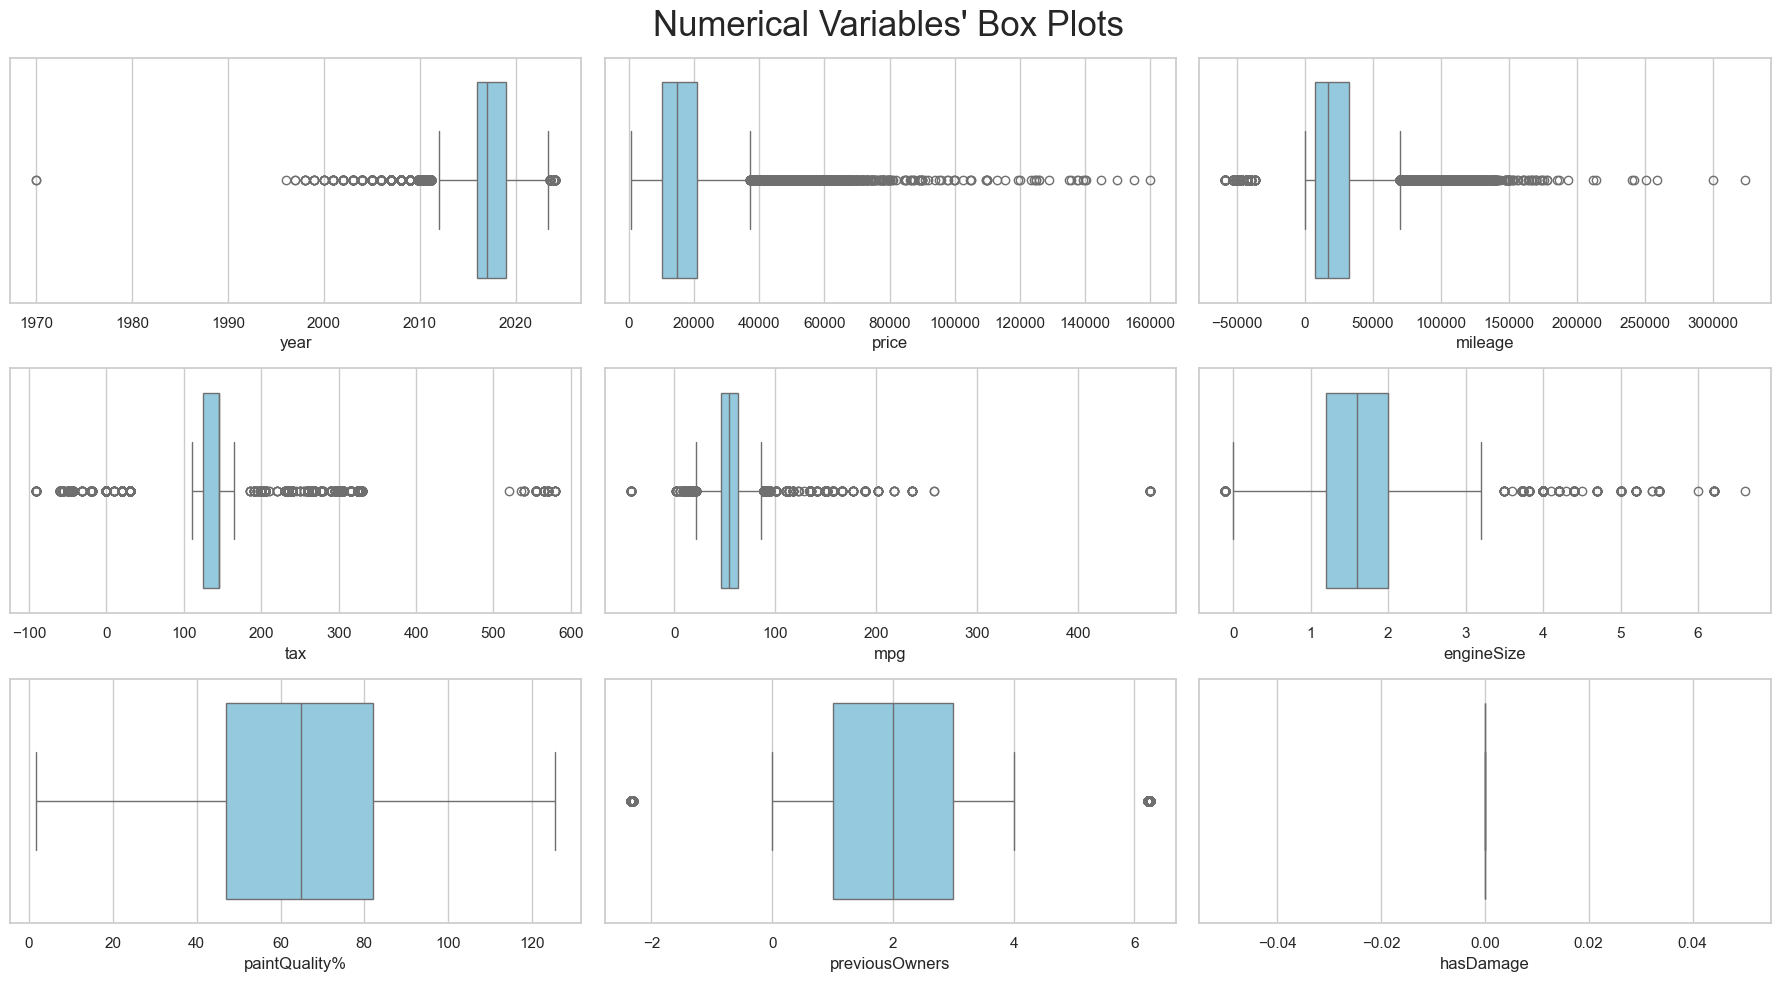

In [21]:

fig, axes = plt.subplots(ceil(len(numeric_features) / 3 ), 3, figsize = (18,10))

for ax, feat in zip(axes.flatten(), numeric_features):
    sns.boxplot(x=df_train[feat], ax=ax, color='skyblue')

# Delete empty plots
for ax in axes.flatten()[len(numeric_features):]:
    ax.axis('off')

plt.suptitle("Numerical Variables' Box Plots", fontsize=25)

plt.tight_layout()
plt.show()

In [22]:
df_train['hasDamage'].unique()

array([ 0., nan])

The first issues we encounter in the numerical features in the dataset are:

- float years and years above 2020 (the data base is from 2020);
- negative mileage values;
- negative tax values;
- negative/zero mpg values;
- paint quality values above 100%
- negative/zero engine sizes;
- previous owners with negative/float values;

We consider all of these values to be invalid within the context of each of these features. 

Additionally, there is a significant presence of outliers is most variables, except for paintQuality% and hasDamage. The other features show very extreme outliers which results in a compressed distribution.

hasDamage is a particular case: it only contains two values, zero or NA. Hence, its boxplot consists of a single straight line at zero. Since according to the metadata this is a boolean variable, we will assume that zero hasDamage values correspond to cars with no damage and that the missing values correspond to cars with damage.

### **Correlations**

To measure the correlation between numerical variables we decided to use Spearman's coefficient, as it captures monotonic associations, not just linear ones. 

In [23]:
corr = df_train[numeric_features].corr(method="spearman")
corr = corr.round(2)
corr

,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
year,1.00,0.60,-0.78,0.32,-0.31,-0.04,0.00,0.00,NaN
price,0.60,1.00,-0.51,0.31,-0.39,0.56,0.00,-0.00,NaN
mileage,-0.78,-0.51,1.00,-0.25,0.32,0.10,-0.00,0.00,NaN
tax,0.32,0.31,-0.25,1.00,-0.55,0.16,0.00,-0.00,NaN
mpg,-0.31,-0.39,0.32,-0.55,1.00,-0.20,0.00,0.00,NaN
engineSize,-0.04,0.56,0.10,0.16,-0.20,1.00,0.00,0.00,NaN
paintQuality%,0.00,0.00,-0.00,0.00,0.00,0.00,1.00,-0.01,NaN
previousOwners,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.01,1.00,NaN
hasDamage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


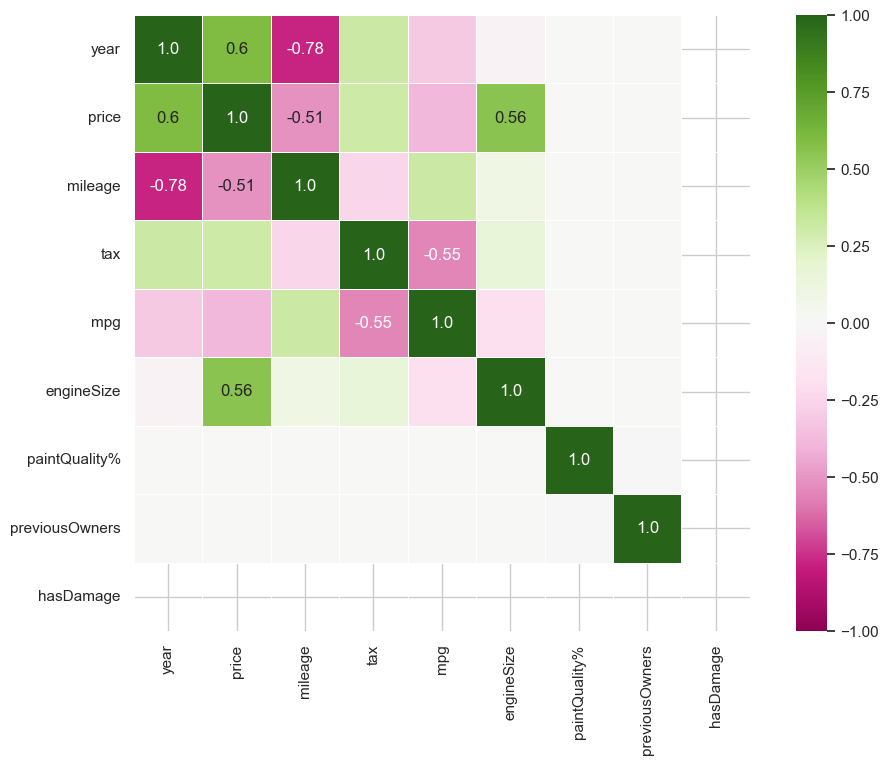

In [24]:

fig = plt.figure(figsize=(12, 8))

mask_annot = np.absolute(corr.values) >= 0.5 
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) 


# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, 
            annot=annot, # Specify custom annotation
            fmt='s', # The annotation matrix now has strings, so we need to explicitly say this
            vmin=-1, vmax=1, 
            center=0, # Center the colormap at zero
            square=True, # Make each cell square-shaped
            linewidths=.5, # Add lines between cells
            cmap='PiYG' # Diverging color map
            )

plt.show()


'previousOwners' and 'paintQuality%' present almost no correlation with the remaining variables, which indicates some degree of irrelevance.

'mileage' and 'year' show strong correlation (in opposite directions).

'mpg' and 'tax' show medium correlation (in opposite directions).

'mpg' and 'year', 'tax' and 'mileage', 'tax' and 'year' show medium-low correlation.

'year', 'mileage' and 'engineSize' show the highest correlation with the target variable, 'price'.

The value of the correlations is probably very affected by the large amount of outliers, missing values and systematic errors.

### **Scatter Plots**


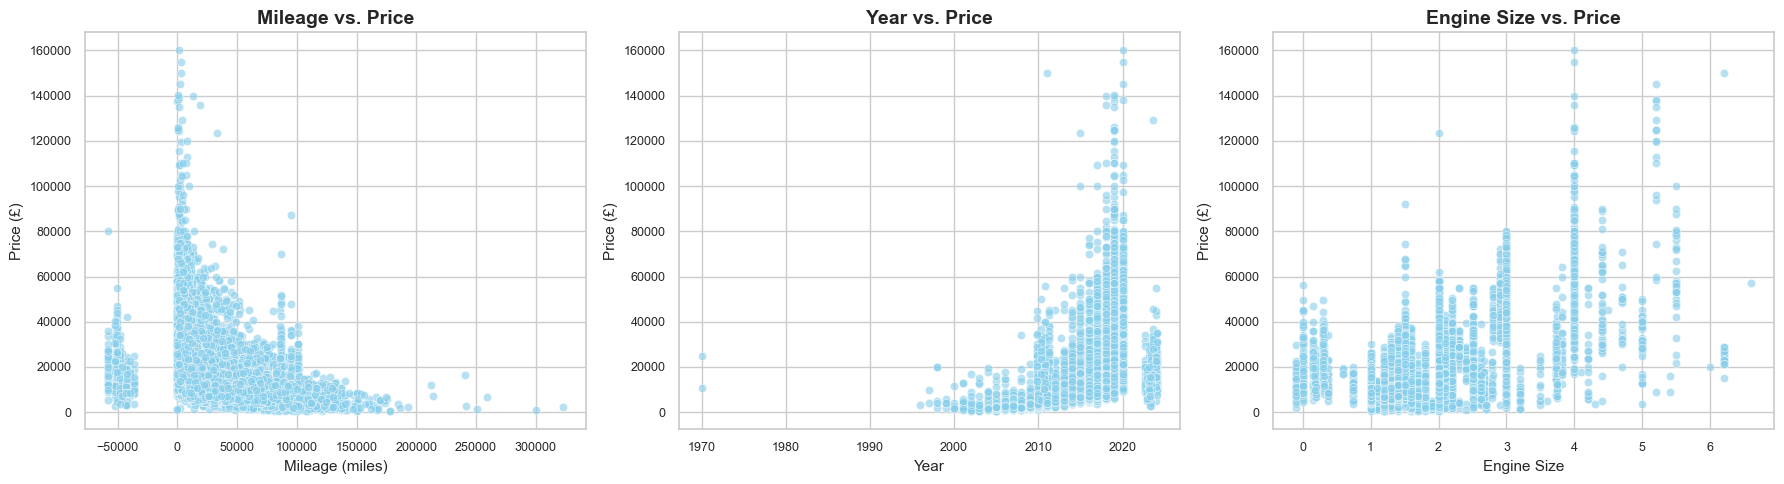

In [25]:

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

variables = ['mileage', 'year', 'engineSize']
titles = ['Mileage vs. Price', 'Year vs. Price', 'Engine Size vs. Price']
xlabels = ['Mileage (miles)', 'Year', 'Engine Size']

for i, (var, title, xlabels) in enumerate(zip(variables, titles, xlabels)):
    sns.scatterplot( data=df_train, x=var, y='price', ax=axes[i], alpha=0.6, color='skyblue' )
    
    axes[i].set_title(title, fontsize=14, fontweight='bold')
    axes[i].set_xlabel(xlabels, fontsize=11)
    axes[i].set_ylabel('Price (£)', fontsize=11)
    axes[i].tick_params(axis='both', labelsize=9)

plt.tight_layout()
plt.show()

The scatter plots are very noisy, as the data has not been treated yet. We can still spot the issues mentioned above.

Nonetheless, as expected, there is a large increase in price for cars with less mileage and older cars are cost less than more recent cars. When it comes to engine size, there seems to be an increase in price as the size increases, although more subtle than the year and mileage patterns.


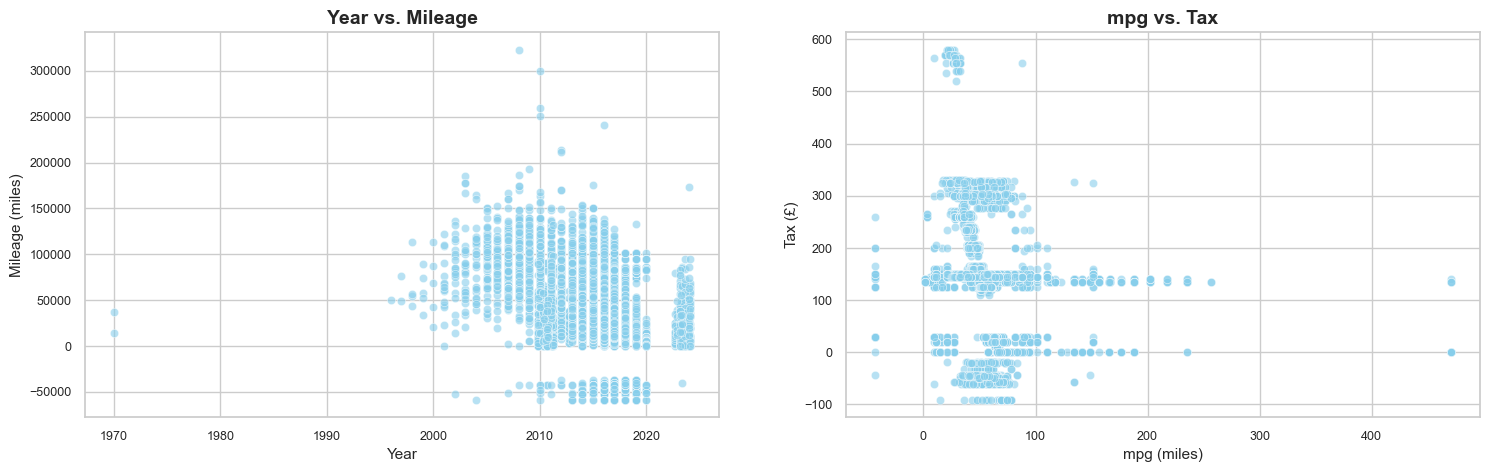

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.scatterplot(data=df_train, x='year', y='mileage', ax=axes[0], alpha=0.6, color='skyblue')
axes[0].set_title('Year vs. Mileage', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=11)
axes[0].set_ylabel('Mileage (miles)', fontsize=11)
axes[0].tick_params(axis='both', labelsize=9)

sns.scatterplot(data=df_train, x='mpg', y='tax', ax=axes[1], alpha=0.6, color='skyblue')
axes[1].set_title('mpg vs. Tax', fontsize=14, fontweight='bold')
axes[1].set_xlabel('mpg (miles)', fontsize=11)
axes[1].set_ylabel('Tax (£)', fontsize=11)
axes[1].tick_params(axis='both', labelsize=9)



Again, the data is very noisy and in th Year vs. Mileage and mpg vs. Tax scatter plots it is harder to spot a pattern. 

<h3 id="5th-bullet" style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> 2.3 Data Preparation </strong>
</h3>


We will now perform some pre-processing of the variables to facilitate their treatment within the implementation of the hold-out method.


<h3 style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> Pre-Processing of Numerical Variables </strong>
</h3>

As mentioned before, we are faced with the following challenges:

- years above 2020 (the data base is from 2020);
- negative mileage values;
- negative tax values;
- negative/zero mpg values;
- paint quality values above 100%
- negative/zero engine size;
- previous owners with negative values;

We consider all of these values to be invalid within the context of each of these features and treat them as missing values.

In [27]:
invalid_train = ((df_train['year']>2020) | (df_train['mileage']<0) | (df_train['tax']<0) | 
           (df_train['mpg']<=0) | (df_train['paintQuality%']>100) | (df_train['previousOwners']< 0) | (df_train['engineSize']<= 0))


invalid_ratio = round(df_train[invalid_train].shape[0]/ df_train.shape[0] * 100,2)

print(f"Rows with invalid values account for {invalid_ratio}% of the original train set.")

Rows with invalid values account for 2.78% of the original train set.


In [28]:
df_train.loc[df_train['year']>2020, 'year'] = np.nan
df_test.loc[df_test['year']>2020, 'year'] = np.nan

df_train.loc[df_train['mileage']<0, 'mileage'] = np.nan
df_test.loc[df_test['mileage']<0, 'mileage'] = np.nan

df_train.loc[df_train['tax']<0, 'tax'] = np.nan
df_test.loc[df_test['tax']<0,'tax'] = np.nan

df_train.loc[df_train['mpg']<=0, 'mpg'] = np.nan
df_test.loc[df_test['mpg']<=0, 'mpg'] = np.nan

df_train.loc[df_train['paintQuality%']>100, 'paintQuality%'] = np.nan
df_test.loc[df_test['paintQuality%']>100, 'paintQuality%'] = np.nan

df_train.loc[df_train['previousOwners']< 0, 'previousOwners'] = np.nan
df_test.loc[df_test['previousOwners']< 0, 'previousOwners'] = np.nan

df_train.loc[df_train['engineSize']<= 0, 'engineSize'] = np.nan
df_test.loc[df_test['engineSize']<= 0, 'engineSize'] = np.nan


Additionally, years and previous owners should be whole numbers, so we will round them using the floor function and typecast them into integers.

In [29]:
df_train['year'] = np.floor(df_train['year'])
df_train['previousOwners'] = np.floor(df_train['previousOwners'])

df_test['year'] = np.floor(df_test['year'])
df_test['previousOwners'] = np.floor(df_test['previousOwners'])

There are two other issues:

- really low mpg values (a good standard value for cars from after the 2000s should be around 40 mpg); for example the minimum year for cars below 15 mpg in our dataset is 2005, which is not feasible.

- really small engine sizes: a minimum standard value should be 1 L;

For these reasons, we will replace mpg values below 40 and engine sizes below 1 L with missing values to be treated later.

In [30]:
df_train.loc[df_train['mpg']<15, 'year'].describe()

count     194.000000
mean     2017.494845
std         2.292695
min      2005.000000
25%      2016.000000
50%      2018.000000
75%      2019.000000
max      2020.000000
Name: year, dtype: float64

In [31]:
df_train.loc[df_train['mpg'] < 40, 'mpg'] = np.nan
df_train.loc[df_train['engineSize'] < 1, 'engineSize'] = np.nan

df_test.loc[df_test['mpg'] < 40, 'mpg'] = np.nan
df_test.loc[df_test['engineSize'] < 1, 'engineSize'] = np.nan

We'll also round the floats to two decimal places.

In [32]:
for feat in ['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%']:
    df_train[feat] = df_train[feat].round(2)
    df_test[feat] = df_test[feat].round(2)


<h3 style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> Pre-Processing of Categorical Variables </strong>
</h3>

Pre-processing the categorical variables will allow for an easier treatment. Therefore, we will transform all the categorical features into strings, strip them of leading and trace spaces and convert them to upper case.

In [33]:
# Pre processing the categorical variables to be easier to find clusters in typos:
    # remove spaces (at the beginning and end) and uppercase all letters
    # does not replace NaN's
df_train['Brand'] = df_train['Brand'].where(df_train['Brand'].isna(), df_train['Brand'].astype(str).str.strip().str.upper())
df_test['Brand']  = df_test['Brand'].where(df_test['Brand'].isna(), df_test['Brand'].astype(str).str.strip().str.upper())

df_train['model'] = df_train['model'].where(df_train['model'].isna(), df_train['model'].astype(str).str.strip().str.upper())
df_test['model']  = df_test['model'].where(df_test['model'].isna(), df_test['model'].astype(str).str.strip().str.upper())

df_train['fuelType'] = df_train['fuelType'].where(df_train['fuelType'].isna(), df_train['fuelType'].astype(str).str.strip().str.upper())
df_test['fuelType']  = df_test['fuelType'].where(df_test['fuelType'].isna(), df_test['fuelType'].astype(str).str.strip().str.upper())

df_train['transmission'] = df_train['transmission'].where(df_train['transmission'].isna(), df_train['transmission'].astype(str).str.strip().str.upper())
df_test['transmission']  = df_test['transmission'].where(df_test['transmission'].isna(), df_test['transmission'].astype(str).str.strip().str.upper())


<h3 style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> Hold-Out Method </strong>
</h3>

For this deliverable, we will be implementing a linear regression model through the hold-out method. 

We start by separating the target variable from the remaining variables and then splitting both sets into train and validation sets, using train_test_split from sklearn. We will use a 80%-20% train-validation proportion for this. 

In [34]:
target = df_train['price']
data = df_train.drop(['price'],axis=1)

In [35]:
X_train, X_val, y_train, y_val = train_test_split(data, 
                                                 target, 
                                                 test_size=0.3, 
                                                 random_state=15, 
                                                 shuffle=True)


<h3 style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> Treatment of Categorical Variables </strong>
</h3>

##### *Brands*

In [36]:
brands = X_train['Brand'].dropna().unique().tolist()
print(f' Typos in brands: {brands}')

 Typos in brands: ['MERCEDES', 'VW', 'AUDI', 'FORD', 'TOYOTA', 'BMW', 'SKODA', 'OPEL', 'HYUNDAI', 'OPE', 'W', 'BM', 'KODA', 'PEL', 'TOYOT', 'OYOTA', 'V', 'ERCEDES', 'UDI', 'FOR', 'SKOD', 'MERCEDE', 'HYUNDA', 'ORD', 'YUNDAI', 'AUD', 'MW', 'ERCEDE', 'OR', 'PE', 'UD', 'KOD', 'YUNDA']


In Brands we have the value 'W' which could mean VW or BMW. 

In [37]:
def correct_brand_w(df, brand, model):

    '''
    The function will switch the observations 'W' with 'BMW' and 'VW' depending on the correspondence of their
    models in other observations. This function is only applied to one element, one brand and the corresponding model

    Parameters
    -----------
    df : DataFrame
        the DataFrame whose columns are to be fixed
        
    brand : string
        the brand 

    model : string
        the corresponding model

    
    Returns
    -----------
    brand : string
        correct model, which will be 'BMW' or 'VW' if the brand is 'W', and the input brand otherwise
    

    '''

    # If the brand is 'w' and its a string
    if isinstance(brand, str) and brand == 'W':

        # For cicle to go over the brands and corresponding models in the DataFrame
        for brand_in_column, model_in_column in zip(df['Brand'], df['model']):

            # If the same model is found, then return the corresponding brand
            if isinstance(brand_in_column, str) and model_in_column == model and brand_in_column != 'W':
                print (brand_in_column)
                return brand_in_column
            
    # If the brand is not 'W', it remains the same           
    return brand

# Correct the  'W' values in the columns 'Brand' by applying the function correct_brand_w to all elements in the column
X_train['Brand'] = X_train.apply(lambda row: correct_brand_w(X_train, row['Brand'], row['model']),axis=1)

VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW


In [38]:
X_val['Brand'] = X_val.apply(lambda row: correct_brand_w(X_val, row['Brand'], row['model']), axis = 1)

VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW


In [39]:
df_test['Brand'] = df_test.apply(lambda row: correct_brand_w(df_test, row['Brand'], row['model']), axis = 1)

VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW


In [40]:
print(f'Train: {X_train[(X_train['Brand']=='W')]}\n\n')
print(f'Validation: {X_val[(X_val['Brand']=='W')]}\n\n')
print(f'Test: {df_test[(df_test['Brand']=='W')]}')

Train:       Brand model    year transmission  mileage fuelType    tax   mpg  \
carID                                                                   
74210     W   NaN  2019.0    SEMI-AUTO   3700.0   DIESEL  145.0  52.3   
66941     W   NaN  2019.0    AUTOMATIC   6000.0      NaN  145.0   NaN   

       engineSize  paintQuality%  previousOwners  hasDamage  
carID                                                        
74210         2.0           87.0             3.0        0.0  
66941         1.5           70.0             3.0        0.0  


Validation:       Brand model    year transmission  mileage fuelType    tax   mpg  \
carID                                                                   
65456     W   NaN  2019.0       MANUAL   3000.0   DIESEL  145.0  57.7   

       engineSize  paintQuality%  previousOwners  hasDamage  
carID                                                        
65456         1.6           38.0             2.0        0.0  


Test:        Brand model    ye

We can see that we fixed the problem with the brand 'w' except for the cases with null values, which are only 5 observations. The ones that were fixed were all 'VW' so we will assume the same for these.

In [41]:
X_train.loc[X_train['Brand'] =='W' ,'Brand'] = 'VW'

X_val.loc[X_val['Brand'] =='W' ,'Brand'] = 'VW'

df_test.loc[df_test['Brand'] =='W' ,'Brand'] = 'VW'

print(X_train[X_train['Brand'] =='W'], '\n\n')
print(X_val[X_val['Brand'] =='W'], '\n\n')
print(df_test[df_test['Brand']=='W'])


Empty DataFrame
Columns: [Brand, model, year, transmission, mileage, fuelType, tax, mpg, engineSize, paintQuality%, previousOwners, hasDamage]
Index: [] 


Empty DataFrame
Columns: [Brand, model, year, transmission, mileage, fuelType, tax, mpg, engineSize, paintQuality%, previousOwners, hasDamage]
Index: [] 


Empty DataFrame
Columns: [Brand, model, year, transmission, mileage, fuelType, tax, mpg, engineSize, paintQuality%, previousOwners, hasDamage]
Index: []


For all variables, we will follow the same logic. We will group the typos into clusters based only on the typos from the **training data**. Then, we will correct the errors in training, validation and testing based on the created clusters. If the typo isnt in the clusters we'll try to match it to correct values from train.

Lets correct the typos:

TheFuzz uses the Levenshtein edit distance to calculate the degree of closeness between two strings.

**Levenshtein distance** = at a minimum, how many edits are required to change one string into the other.

In [42]:
brands = X_train['Brand'].dropna().unique().tolist()

In [43]:
set([len(brand) for brand in brands])

{1, 2, 3, 4, 5, 6, 7, 8}

[https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings]

[https://medium.com/@laxmi17sarki/string-matching-using-fuzzywuzzy-24be9e85c88d]

**Ratio choice**: fuzz.WRatio, most robust method

In [44]:
def create_clusters(brand_list, column, threshold=85): 
      
    """
    Groups similar strings into clusters and creates a mapping to the most frequent name in each cluster.

    The function checks each element in `brand_list` and groups together all elements whose similarity (calculated using fuzz.WRatio) is greater than or equal to `threshold`. 
    Then, for each cluster, it selects the most common name within that cluster as the representative name, creating a mapping for standardizing the names.

    Parameters
    ----------
    brand_list : list
        List of strings (e.g., brand names) to be clustered.
    
    column : str
        Name of the column in the DataFrame `X_train` where the original elements are located.
    
    threshold : int, default=85
        Minimum similarity percentage (0-100) to consider two strings as belonging to the same cluster. The higher the value, the stricter the grouping.

    Returns
    -------
    clusters : list of lists
        List of clusters, where each cluster is a list of similar strings.
    
    mapping : dict
        Dictionary mapping each original string to the representative name of its cluster (the most frequent name in the cluster).
    """
    
    clusters = []
    for brand in brand_list:
        found = False
        for cluster in clusters:
            # evaluates if brand is similar to any cluster
            if any(fuzz.WRatio(str(brand), str(b)) >= threshold for b in cluster):
                cluster.append(brand)
                found = True
                break
        #if it doesn't find a match --> new cluster
        if not found:
            clusters.append([brand])

    # Gives the clusters names- chooses the most freq name
    mapping = {}
    counts = X_train[column].value_counts()
    for cluster in clusters:
        mode = max(cluster, key=lambda x: counts.get(x,0))  #finds the "max" in the cluster according to the key --> mode
        for brand in cluster:
            mapping[brand] = str(mode)

    return clusters, mapping

def correct_categorical (mapping, value, threshold=85):
     
    """
    Corrects a categorical value based on a given mapping or fuzzy string matching.

    The function attempts to standardize a categorical `value`:
    1. If the value exists as a key in `mapping`, it returns the corresponding mapped value.
    2. Otherwise, it compares the value with all unique mapped values using fuzzy string matching (WRatio).
    If a match is found with a similarity greater than or equal to `threshold`, it returns the best match.
    3. If no match is found, it returns the original value.

    Parameters
    ----------
    mapping : dict
        Dictionary mapping known categorical values to their standardized form.
    
    value : str
        The categorical value to be corrected.
    
    threshold : int, default=85
        Minimum similarity percentage (0-100) required to consider a fuzzy match valid.

    Returns
    -------
    str
        The corrected categorical value, either from the mapping, from the best fuzzy match, 
        or the original value if no match is found.
    """

    unique_values = list(mapping.keys())
    if value in unique_values:
        return mapping [value] 
    else: 
        correct_values = set(mapping.values())
        value_match = ''
        max_ratio = threshold
        for element in correct_values:
            if (fuzz.WRatio(str(element), str(value)) >= max_ratio):
                max_ratio= fuzz.WRatio(str(element), str(value))
                value_match = element
        if value_match != '': 
            return value_match
        else:
            return value
            
clusters, mapping = create_clusters(brands, 'Brand')

print("Clusters:")
for c in clusters:
    print(c)

X_train['Brand_cleaned'] = X_train['Brand'].apply(lambda x: correct_categorical(mapping, x))
X_val['Brand_cleaned'] = X_val['Brand'].apply(lambda x: correct_categorical(mapping, x))
df_test['Brand_cleaned'] = df_test['Brand'].apply(lambda x: correct_categorical(mapping, x))

print("\nCleaned brand - Train:")
print(X_train['Brand_cleaned'].dropna().unique())

print("\nCleaned brand - Validation:")
print(X_val['Brand_cleaned'].dropna().unique())

print("\nCleaned brand - Test:")
print(df_test['Brand_cleaned'].dropna().unique())


Clusters:
['MERCEDES', 'ERCEDES', 'MERCEDE', 'ERCEDE']
['VW', 'V']
['AUDI', 'UDI', 'AUD', 'UD']
['FORD', 'FOR', 'ORD', 'OR']
['TOYOTA', 'TOYOT', 'OYOTA']
['BMW', 'BM', 'MW']
['SKODA', 'KODA', 'SKOD', 'KOD']
['OPEL', 'OPE', 'PEL', 'PE']
['HYUNDAI', 'HYUNDA', 'YUNDAI', 'YUNDA']

Cleaned brand - Train:
['MERCEDES' 'VW' 'AUDI' 'FORD' 'TOYOTA' 'BMW' 'SKODA' 'OPEL' 'HYUNDAI']

Cleaned brand - Validation:
['BMW' 'OPEL' 'AUDI' 'MERCEDES' 'FORD' 'TOYOTA' 'VW' 'HYUNDAI' 'SKODA']

Cleaned brand - Test:
['HYUNDAI' 'VW' 'BMW' 'OPEL' 'FORD' 'MERCEDES' 'SKODA' 'TOYOTA' 'AUDI']


#### *Transmission*

In [45]:
transmission_types = X_train['transmission'].dropna().unique().tolist()
print(f' Typos in models: {transmission_types}')

 Typos in models: ['SEMI-AUT', 'AUTOMATIC', 'SEMI-AUTO', 'MANUAL', 'MANUA', 'ANUAL', 'AUTOMATI', 'UNKNOW', 'UNKNOWN', 'UTOMATIC', 'EMI-AUTO', 'ANUA', 'NKNOWN', 'OTHER', 'UTOMATI', 'EMI-AUT', 'NKNOW']


In [46]:
# Creates clusters with similar fuel types
clusters, mapping = create_clusters(transmission_types, 'transmission')

X_train['transmission_cleaned'] = X_train['transmission'].apply(lambda x: correct_categorical(mapping, x))
X_val['transmission_cleaned'] = X_val['transmission'].apply(lambda x: correct_categorical(mapping, x))
df_test['transmission_cleaned'] = df_test['transmission'].apply(lambda x: correct_categorical(mapping, x))

print("Clusters:")
for c in clusters:
    print(c)

print("\nCleaned transmission - Train:")
print(X_train['transmission_cleaned'].dropna().unique())

print("\nCleaned transmission - Validation:")
print(X_val['transmission_cleaned'].dropna().unique())

print("\nCleaned transmission - Test:")
print(df_test['transmission_cleaned'].dropna().unique())

Clusters:
['SEMI-AUT', 'SEMI-AUTO', 'EMI-AUTO', 'EMI-AUT']
['AUTOMATIC', 'AUTOMATI', 'UTOMATIC', 'UTOMATI']
['MANUAL', 'MANUA', 'ANUAL', 'ANUA']
['UNKNOW', 'UNKNOWN', 'NKNOWN', 'NKNOW']
['OTHER']

Cleaned transmission - Train:
['SEMI-AUTO' 'AUTOMATIC' 'MANUAL' 'UNKNOWN' 'OTHER']

Cleaned transmission - Validation:
['SEMI-AUTO' 'MANUAL' 'AUTOMATIC' 'UNKNOWN' 'OTHER']

Cleaned transmission - Test:
['AUTOMATIC' 'SEMI-AUTO' 'MANUAL' 'UNKNOWN' 'OTHER']


#### *Fuel Types*

In [47]:
fuel_types=X_train['fuelType'].dropna().unique().tolist()
print(f' Typos in models: {fuel_types}')

 Typos in models: ['DIESEL', 'PETROL', 'DIESE', 'HYBRID', 'IESEL', 'PETRO', 'ETROL', 'YBRID', 'ELECTRIC', 'IESE', 'OTHER', 'HYBRI', 'ETRO', 'THER', 'OTHE', 'YBRI']


In [48]:
# Creates clusters with similar fuel types
clusters, mapping = create_clusters(fuel_types, 'fuelType')

X_train['fuelType_cleaned'] = X_train['fuelType'].apply(lambda x: correct_categorical(mapping, x))
X_val['fuelType_cleaned'] = X_val['fuelType'].apply(lambda x: correct_categorical(mapping, x))
df_test['fuelType_cleaned'] =  df_test['fuelType'].apply(lambda x: correct_categorical(mapping, x))

print("Clusters:")
for c in clusters:
    print(c)

print("\nCleaned fuel type - Train:")
print(X_train['fuelType_cleaned'].dropna().unique())

print("\nCleaned fuel type - Validation:")
print(X_val['fuelType_cleaned'].dropna().unique())

print("\nCleaned fuel type - Test:")
print(df_test['fuelType_cleaned'].dropna().unique())

Clusters:
['DIESEL', 'DIESE', 'IESEL', 'IESE']
['PETROL', 'PETRO', 'ETROL', 'ETRO']
['HYBRID', 'YBRID', 'HYBRI', 'YBRI']
['ELECTRIC']
['OTHER', 'THER', 'OTHE']

Cleaned fuel type - Train:
['DIESEL' 'PETROL' 'HYBRID' 'ELECTRIC' 'OTHER']

Cleaned fuel type - Validation:
['DIESEL' 'PETROL' 'HYBRID' 'OTHER']

Cleaned fuel type - Test:
['PETROL' 'DIESEL' 'HYBRID' 'OTHER' 'ELECTRIC']


#### *Models*

In [49]:
models= X_train['model'].dropna().unique().tolist()
print(f'Nº of unique values: {len(models)}')

Nº of unique values: 283


In [50]:
set([len(str(model)) for model in models])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21}

Fuzzywuzzy wasnt able to group the same models in the column 'model', so for this case we will use get_close_matches from difflib:

In [51]:
def similar_models(models, threshold=0.85):

    '''
    The function will group similar models together based on a similarity threshold, with the goal to identify potential typos.

    Parameters
    -----------
    models : List[str]
        List with all the unique elements in the 'model' column

    threshold : float , default=0.85
        The similarity threshold for grouping models. 

    Returns
    -----------
    similar_groups : List[List[str]]
        A list of lists, where each inner list contains the models that are similar to each other based on the threshold.
    '''

    # This list, which starts as an empty list, will store the similar groups of strings
    similar_groups = []
    
    # Start a for loop that will go over all the values in models
    for model in models:

        # Transform de list of lists in a unique list with all the values in the sublists
        similar_groups_flat = [item for sublist in similar_groups if sublist is not None for item in sublist]

        if model in similar_groups_flat:

            # If the model is already in similar_groups_flat, then it already has its similarity group, no need to serach for more
            continue
        else:
             
             # Calculate the similarity between model and the other observations and keep the ones with a similarity higher than 0.85
             close_matches = get_close_matches(model, models, cutoff=threshold)

             model_prefix =  model.split(" ")[0] 
             
             # For the models with more than one word it is necessary to evaluate the prefix in order to separate them well
             if " " in model:

                # Only keep the models with the same model code/ prefix. Different model codes belong to different models
                close_matches = [match for match in close_matches if match.split(" ")[0] == model_prefix]

            # Add the close matches to the list of similar groups
             similar_groups.append(close_matches)

    return similar_groups

clusters = similar_models (models)

print("Clusters:")
for c in clusters:
    print(c)

Clusters:
['CLS CLASS', 'CLS CLAS']
['TIGUAN', 'TIGUA']
['PASSAT', 'PASSA']
['GLC CLASS', 'GLC CLAS']
['A5']
['A6']
['AYGO', 'AYG']
['3 SERIES', '3 SERIE']
['FABIA', 'FABI']
['FOCUS', 'FOCU']
['MONDEO', 'MONDE']
['CORSA', 'CORS']
['2 SERIES', '2 SERIE']
['YARIS', 'YARI']
['I30']
['GRAND TOURNEO CONNECT', 'GRAND TOURNEO CONNEC']
['S-MAX', 'S-MA']
['E CLASS', 'E CLAS']
['CROSSLAND X', 'CROSSLAND']
['Q2']
['PRIUS']
['FIESTA', 'FIEST']
['POLO', 'POL']
['I10']
['ASTRA', 'ASTR']
['OCTAVIA', 'OCTAVI']
['Q3']
['GOLF', 'GOL']
['MOKKA X']
['KA+']
['SCALA', 'SCAL']
['ECOSPORT', 'ECOSPOR']
['7 SERIES', '7 SERIE']
['KUGA', 'KUG']
['T-CROSS', 'T-CROS']
['C CLASS', 'C CLAS']
['AURIS', 'AURI']
['PUMA']
['MOKKA', 'MOKK']
['COROLLA', 'COROLL']
['INSIGNIA', 'INSIGNI']
['1 SERIES', '1 SERIE']
['A4']
['GLA CLASS', 'GLA CLAS']
['IONIQ', 'IONI']
['CC']
['COMBO LIFE', 'COMBO LIF']
['8 SERIES', '8 SERIE']
['X1']
['RAV4', 'RAV']
['T-ROC', 'T-RO']
['C-MAX', 'C-MA']
['SL CLASS', 'SL CLAS']
['ZAFIRA', 'ZAFIR']
['V

In [52]:
# Calculate counts once before the function
model_counts = df_train['model'].value_counts().to_dict()

# List to store the most frequent model in each cluster which will be considered the correct one
correct_models = []

# Dictionary to map each model to its correct version
model_mapping = {}

# For loop to go over all the clusters 
for group in clusters:

    # The best model of each cluster will be the one with the highest count in the train set, it will be added to the correct_models list
    best_model = max(group, key=lambda x: model_counts.get(x, 0))
    correct_models.append(best_model)

    # Map all models in the group to the best model
    for model in group:
        model_mapping[model] = best_model



def correct_column_model(model, similar_groups, threshold = 0.85):


    '''
    The function will correct the typos in the 'model' column by mapping each model to its most frequent version in the train set if it
    appears in the train dataset. If the model is an unseen model, it will find the most similar model based on a similarity threshold
    to the list of correct models.

    Parameters
    -----------
    models : String
        The model name to correct.

    similar_groups : List[List[str]]
        A list of lists, where each inner list contains the models that are similar to each other based on the threshold.

    threshold : float, default = 0.85
        The similarity threshold for grouping models.

    Returns
    -----------
    model : String
        The corrected model name, or the original model name if no correction was made.

    '''

    

    # If the element is NA or an empty string then nothing is changed
    if pd.isna(model) or model == ' ':
        return model
    
    # If the model has only one character then it is not possible to associate it with any model so return NA
    elif len(model) == 1:
        return np.nan

    # Transform de list of lists in a unique list with all the values in the sublists
    similar_groups_flat = [item for sublist in similar_groups if sublist is not None for item in sublist]

    # If the model is in similar_groups_flat, then it is in the train set and can be mapped to its correct version
    if model in similar_groups_flat:
        return model_mapping[model]
    
    # If the model has not been seen in the train set, then it will calculate the closest match to the list of correct models
    else:

        # Calculate the similarity between model and the correct models, if the one with highest similarity is above the threshold, then return it
        best_match = get_close_matches(model, correct_models, n=1, cutoff = threshold)

        # If there is a best match above the threshold, return it
        if best_match:
            return best_match[0]
        
        # If there wasnt a match above the threshold, return the original model
        else:
            return model


X_train['model_cleaned'] = X_train['model'].apply(lambda x: correct_column_model(x, clusters))
X_val['model_cleaned'] = X_val['model'].apply(lambda x: correct_column_model(x, clusters))
df_test['model_cleaned'] =  df_test['model'].apply(lambda x: correct_column_model(x,clusters))

In [53]:

print("\nCleaned model - Train:")
print(X_train['model_cleaned'].dropna().unique())

print("\nCleaned model - Validation:")
print(X_val['model_cleaned'].dropna().unique())

print("\nCleaned model - Test:")
print(df_test['model_cleaned'].dropna().unique())


Cleaned model - Train:
['CLS CLASS' 'TIGUAN' 'PASSAT' 'GLC CLASS' 'A5' 'A6' 'AYGO' '3 SERIES'
 'FABIA' 'FOCUS' 'MONDEO' 'CORSA' '2 SERIES' 'YARIS' 'I30'
 'GRAND TOURNEO CONNECT' 'S-MAX' 'E CLASS' 'CROSSLAND X' 'Q2' 'PRIUS'
 'FIESTA' 'POLO' 'I10' 'ASTRA' 'OCTAVIA' 'Q3' 'GOLF' 'MOKKA X' 'KA+'
 'SCALA' 'ECOSPORT' '7 SERIES' 'KUGA' 'T-CROSS' 'C CLASS' 'AURIS' 'PUMA'
 'MOKKA' 'COROLLA' 'INSIGNIA' '1 SERIES' 'A4' 'GLA CLASS' 'IONIQ' 'CC'
 'COMBO LIFE' '8 SERIES' 'X1' 'RAV4' 'T-ROC' 'C-MAX' 'SL CLASS' 'ZAFIRA'
 'VIVA' 'B-MAX' 'CL CLASS' '4 SERIES' 'I800' 'GRANDLAND X' 'KAROQ'
 'SUPERB' 'TOURNEO CUSTOM' 'A CLASS' 'RAPID' 'UP' 'TUCSON' 'A1' 'C-HR'
 'YETI OUTDOOR' 'RS6' 'X5' 'RS3' 'I40' 'X2' 'A3' 'CADDY MAXI LIFE'
 'MERIVA' 'CARAVELLE' 'TOUAREG' 'GRAND C-MAX' 'SUPRA' 'SHARAN' 'KAMIQ'
 'M CLASS' 'GL CLASS' 'Q5' 'I20' 'LAND CRUISER' 'CITIGO' 'GTC' 'KONA'
 'ARTEON' 'GALAXY' 'X3' 'TT' 'Q7' 'KODIAQ' 'YETI' 'VERSO' 'KA' 'M3'
 '5 SERIES' 'ADAM' 'GLE CLASS' 'GLB CLASS' 'AGILA' 'X-CLASS' 'B CLASS'
 'SCI


<h3 style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> Treatment of Numerical Variables </strong>
</h3>

### **Outlier Analysis**

We are now left with outliers, which we will analyse using IQR.

In [54]:
num_feats = ['year', 'mileage', 'tax', 'mpg', 'paintQuality%', 'previousOwners', 'engineSize']

# data frame to assess multi-dimension outliers
outlier_df = pd.DataFrame(False, index=X_train.index, columns=num_feats)
upper_bounds = {}
lower_bounds = {}
# detecting outliers for each numerical feat using IQR method
for feat in num_feats:
    Q1 = X_train[feat].quantile(0.25) 
    Q3 = X_train[feat].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    upper_bounds[feat] = upper # saving IQR bounds of train set to use on validation and test sets
    lower_bounds[feat] = lower

    outlier_mask = ((X_train[feat] < lower) | (X_train[feat] > upper))

    outliers = X_train[outlier_mask]

    print(f"{feat}: {len(outliers)} outliers ({round(len(outliers)/len(X_train),2)}%)\n")


year: 1126 outliers (0.02%)

mileage: 2242 outliers (0.04%)

tax: 14004 outliers (0.26%)

mpg: 563 outliers (0.01%)

paintQuality%: 0 outliers (0.0%)

previousOwners: 0 outliers (0.0%)

engineSize: 421 outliers (0.01%)



In variables where we find it appropriate, we will apply winsorization at either the 1st percentile (for lower-bound IQR outliers), 99th percentile (for upper-bound IQR outliers), or both, affecting 1-2% of data per variable. 

We didn't choose these percentiles taking into account the percentage of outliers within each variable, because if we did, we would end up attributing artificial values to a large amount of outliers that represent genuine values within the context of the dataset.  Instead, we selected these percentiles as to minimize their influence on the model while still addressing extreme values.

- Year: winsorization at 1th percentile:

In [55]:
lower_cap_year = X_train['year'].quantile(0.01)
X_train.loc[X_train['year'] < lower_cap_year,'year'] = lower_cap_year
X_val.loc[X_val['year'] < lower_cap_year,'year'] = lower_cap_year
df_test.loc[df_test['year'] < lower_cap_year,'year'] = lower_cap_year

- Mileage: winsorization at 99th percentile

In [56]:
upper_cap_mile = X_train['mileage'].quantile(0.99)
X_train.loc[X_train['mileage'] > upper_cap_mile,'mileage'] = upper_cap_mile
X_val.loc[X_val['mileage'] > upper_cap_mile,'mileage'] = upper_cap_mile
df_test.loc[df_test['mileage'] > upper_cap_mile,'mileage'] = upper_cap_mile

- Tax: winsorization at 1th and 99th percentile

In [57]:
upper_cap_tax = X_train['tax'].quantile(0.99)
X_train.loc[X_train['tax'] > upper_cap_tax,'tax'] = upper_cap_tax
X_val.loc[X_val['tax'] > upper_cap_tax,'tax'] = upper_cap_tax
df_test.loc[df_test['tax'] > upper_cap_tax,'tax'] = upper_cap_tax

lower_cap_tax = X_train['tax'].quantile(0.01)
X_train.loc[X_train['tax'] < lower_cap_tax,'tax'] = lower_cap_tax
X_val.loc[X_val['tax'] < lower_cap_tax,'tax'] = lower_cap_tax
df_test.loc[df_test['tax'] < lower_cap_tax,'tax'] = lower_cap_tax

- mpg: winsorization at 99th percentile

In [58]:
upper_cap_mpg = X_train['mpg'].quantile(0.99)
X_train.loc[X_train['mpg'] > upper_cap_mpg,'mpg'] = upper_cap_mpg
X_val.loc[X_val['mpg'] > upper_cap_mpg,'mpg'] = upper_cap_mpg
df_test.loc[df_test['mpg'] > upper_cap_mpg,'mpg'] = upper_cap_mpg

In [59]:
upper_cap_engine = X_train['engineSize'].quantile(0.99)
X_train.loc[X_train['engineSize'] > upper_cap_engine,'engineSize'] = upper_cap_engine
X_val.loc[X_val['engineSize'] > upper_cap_engine,'engineSize'] = upper_cap_engine
df_test.loc[df_test['engineSize'] > upper_cap_engine,'engineSize'] = upper_cap_engine

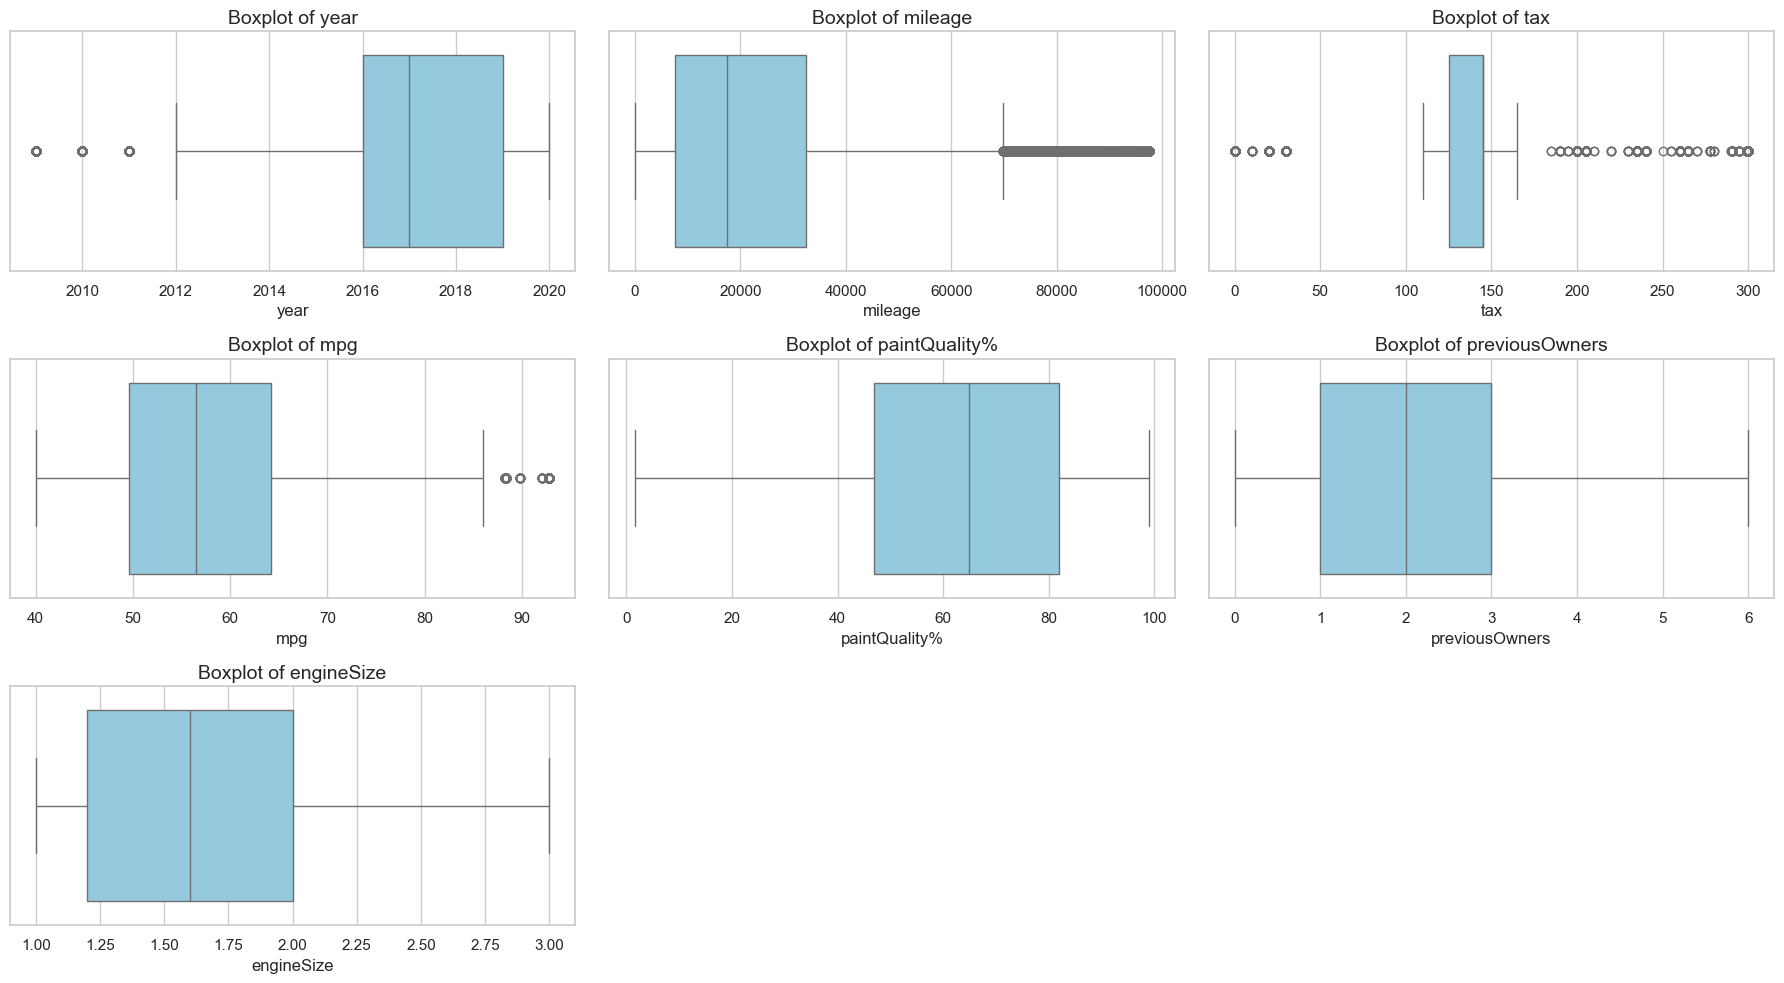

In [60]:
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(num_feats):
    sns.boxplot(x=X_train[var], ax=axes[i], orient='h', color='skyblue')
    axes[i].set_title(f'Boxplot of {var}', fontsize=14)
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('')

for i in range(len(num_feats), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Through winsorization we have diminished the amount of outliers, but some prevail. Linear regression will probably be affected by this, but more robust models will not.

### **hasDamage boolean typecasting**

Since hasDamage is described as a boolean variable in the metadata, we will be assuming that cars with zero values in this variable have no damage and that those with missing values are damaged.

In [61]:
X_train['hasDamage'].isna().replace(True, inplace=True)
X_val['hasDamage'].isna().replace(True, inplace=True)
df_test['hasDamage'].isna().replace(True, inplace=True)

X_train['hasDamage'] = X_train['hasDamage'].astype(bool)
X_val['hasDamage'] = X_val['hasDamage'].astype(bool)
df_test['hasDamage'] = df_test['hasDamage'].astype(bool)



<h3 style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> Visualizing Processed Data </strong>
</h3>

### **Categorical Variables**

We can now visualize the correct bar plots for the categorical variables.

- One-dimensional bar plots

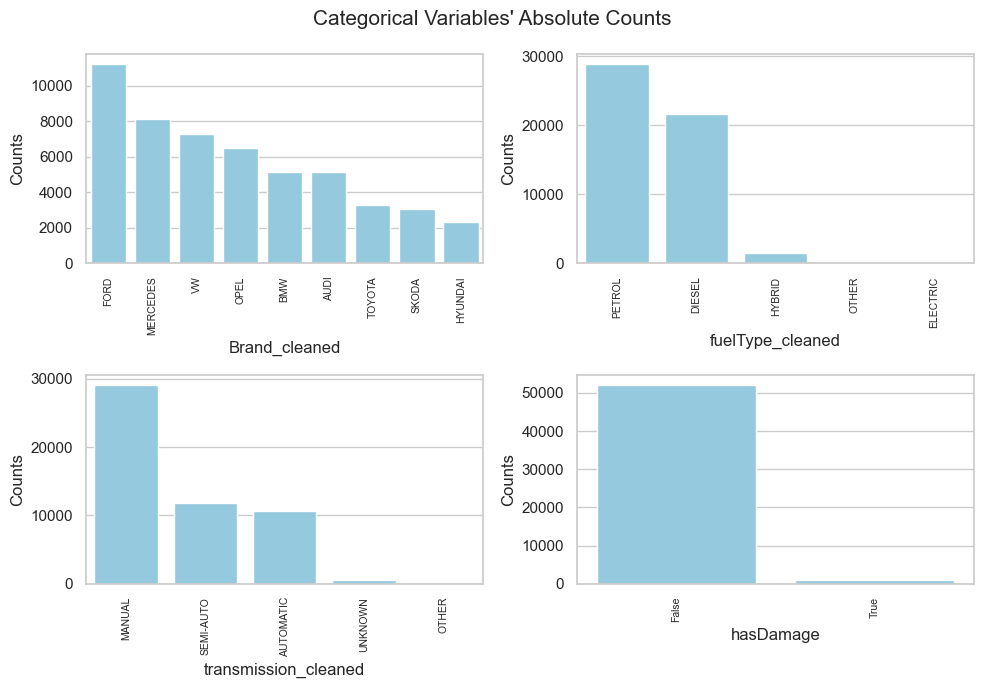

In [62]:
clean_categorical = ['Brand_cleaned', 'fuelType_cleaned', 'transmission_cleaned', 'hasDamage'] # not plotting models as there is a large amount


fig, axes = plt.subplots(
    2, 
    ceil(len(clean_categorical) / 2), 
    figsize=(10, 7)
    )

for ax, feat in zip(axes.flatten(), clean_categorical):
    sns.countplot(x=X_train[feat], ax=ax, 
                  order=X_train[feat].value_counts().index, color = 'skyblue') 
    ax.tick_params(axis='x', rotation=90, labelsize='7.5')  
    ax.set_ylabel('Counts')  


plt.suptitle("Categorical Variables' Absolute Counts", fontsize=15)

plt.tight_layout()
plt.show()

- Multi-variate bar plots

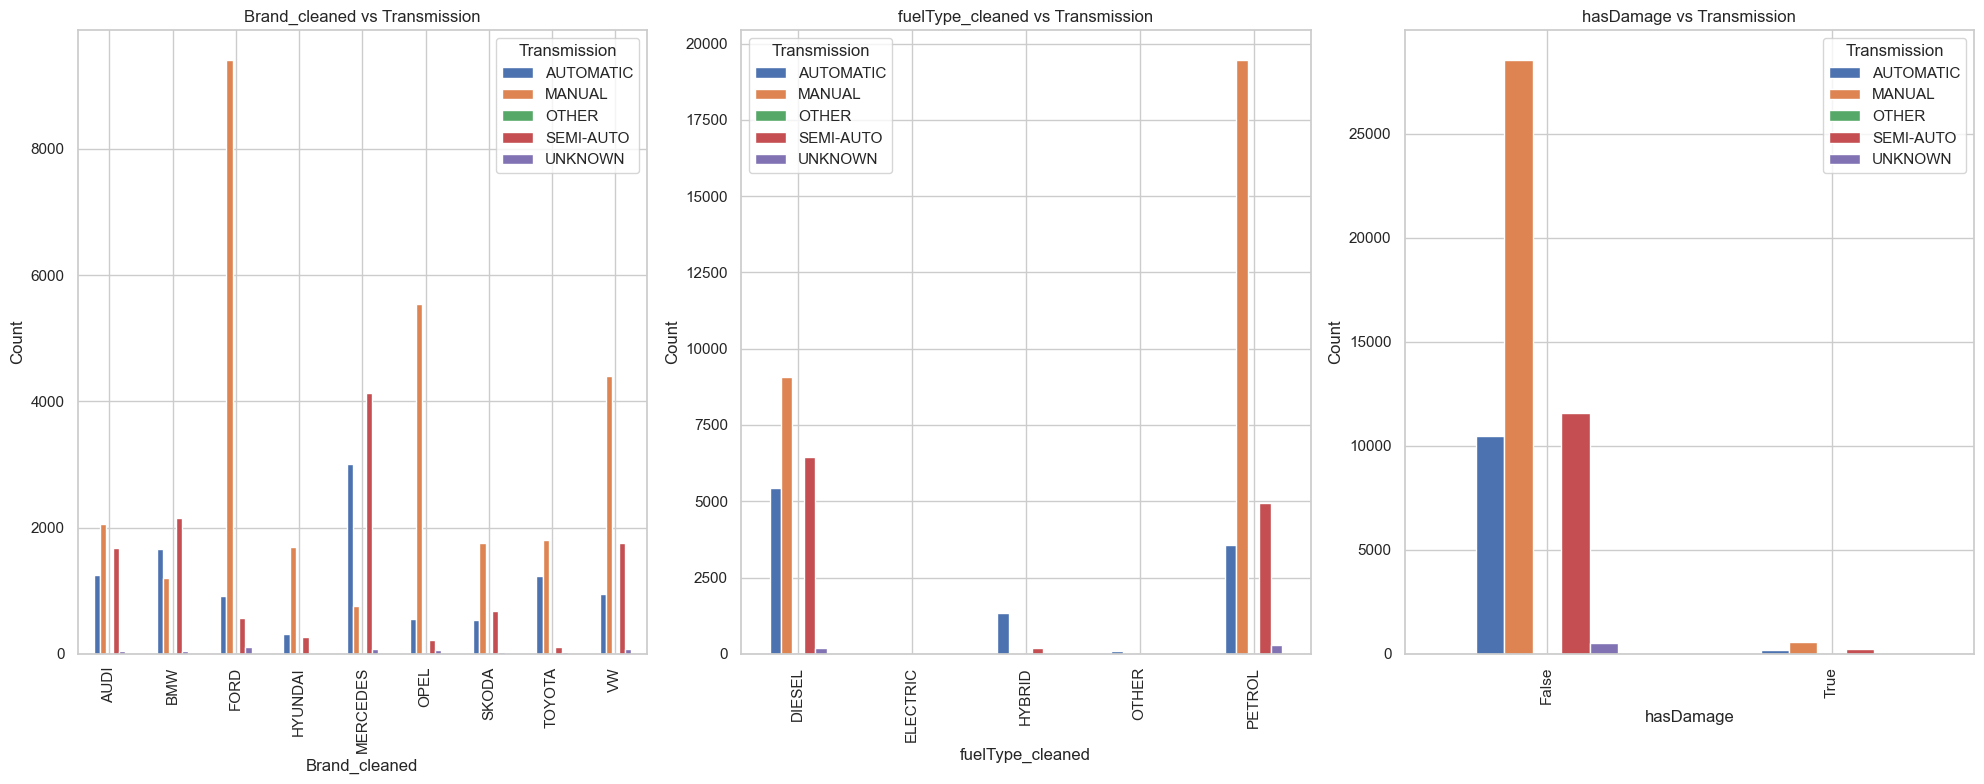

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))


plot_feats = [x for x in clean_categorical if x not in ['transmission_cleaned']]

for i, var in enumerate(plot_feats):
    
    ct = pd.crosstab(X_train[var], X_train['transmission_cleaned'])
    
    ct.plot(kind='bar', ax=axes[i])
    
    axes[i].set_title(f"{var} vs Transmission")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Transmission')

plt.tight_layout()
plt.show()

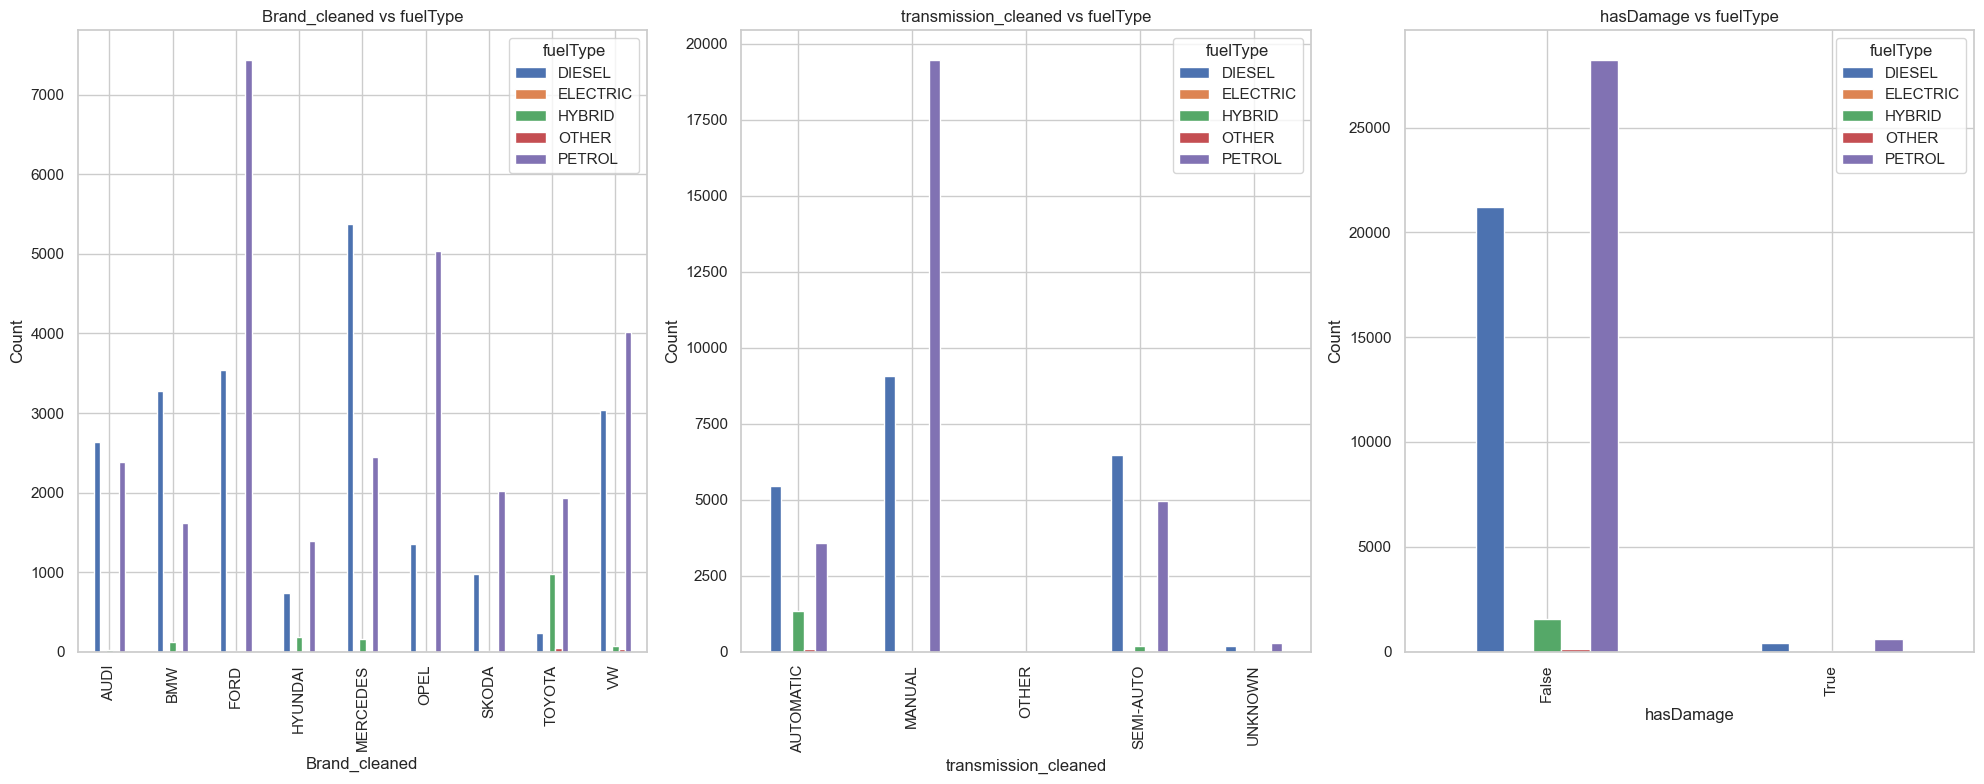

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))


plot_feats = [x for x in clean_categorical if x not in ['fuelType_cleaned']]

for i, var in enumerate(plot_feats):
    
    ct = pd.crosstab(X_train[var], X_train['fuelType_cleaned'])
    
    ct.plot(kind='bar', ax=axes[i])
    
    axes[i].set_title(f"{var} vs fuelType")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='fuelType')

plt.tight_layout()
plt.show()

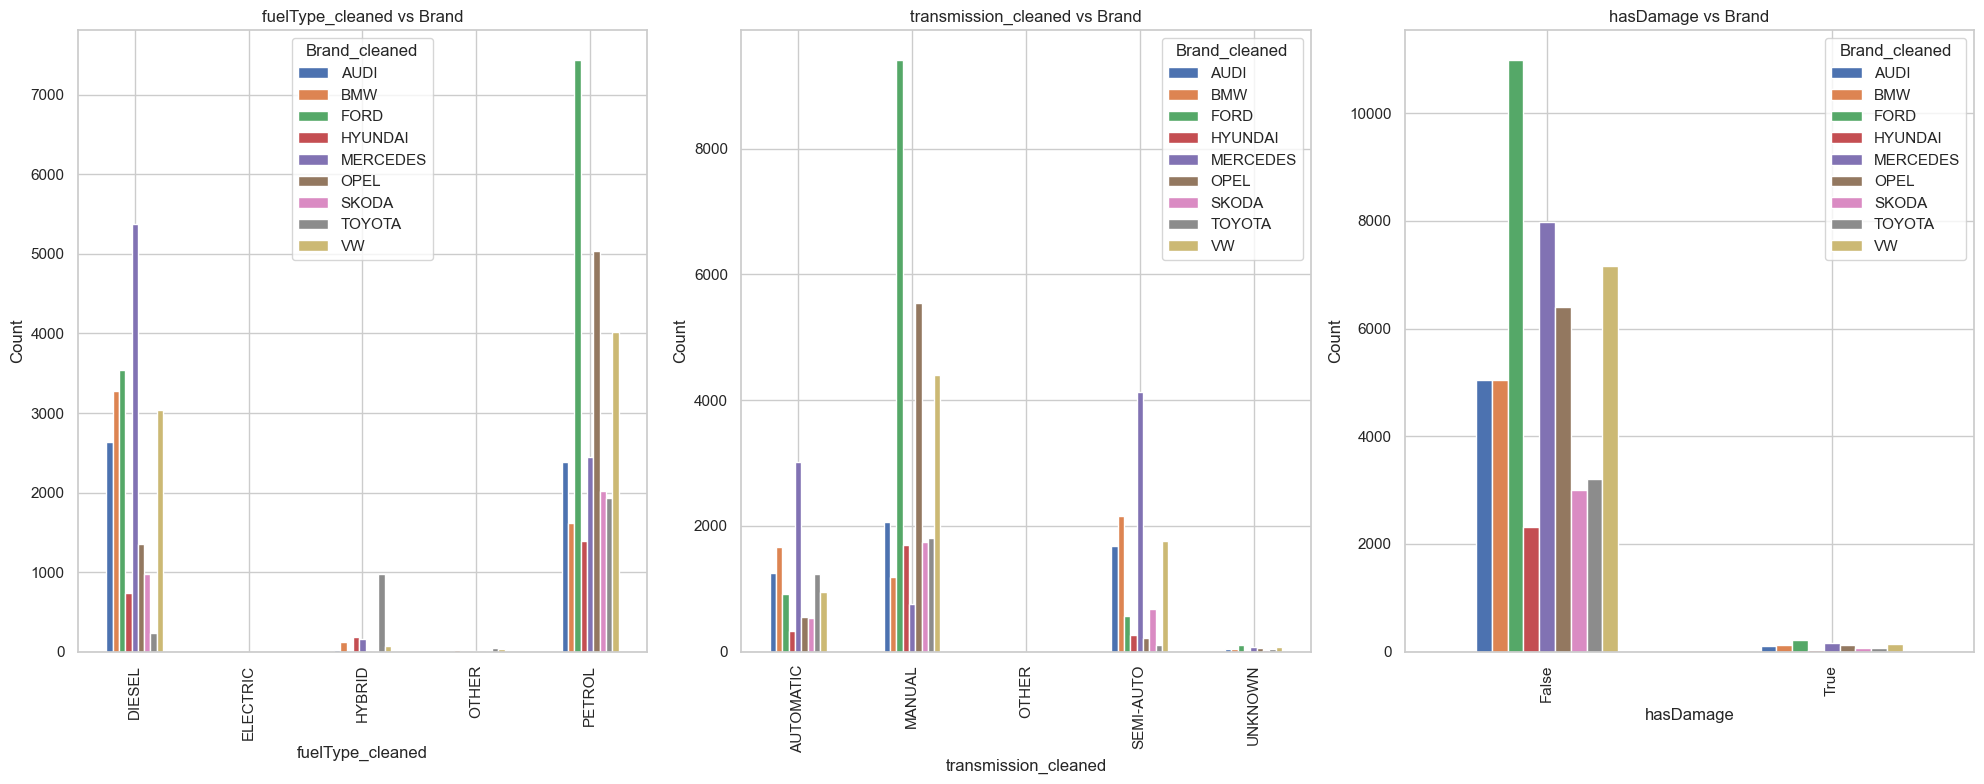

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# choose categorical features except model & fuelType (you can adjust as needed)
plot_feats = [x for x in clean_categorical if x not in ['Brand_cleaned']]

for i, var in enumerate(plot_feats):
    # cross-tabulate the counts of each category vs transmission type
    ct = pd.crosstab(X_train[var], X_train['Brand_cleaned'])
    
    # plot as grouped bar chart
    ct.plot(kind='bar', ax=axes[i])
    
    axes[i].set_title(f"{var} vs Brand")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')


plt.tight_layout()
plt.show()

Performing the Chi-Square test again, we obtain the following results:

In [66]:
clean_categorical.append('model_cleaned')

In [67]:
association_results = pd.DataFrame(columns=clean_categorical, index=clean_categorical)

for var1 in clean_categorical:
    for var2 in clean_categorical:
        #Chi-square test between {var1} and {var2}

        contingency_table = pd.crosstab(X_train[var1], X_train[var2]) # Create the contingency table
        result = chi2_contingency(contingency_table) # Perform the Chi-square test
                                                    #Chi-square Statistic: result[0]
                                                    #p-value: result[1]
                                                    #Degrees of Freedom: result[2]
                                                    #Expected Frequencies: result[3]
        association_results.loc[var1, var2] = result[1]

association_results= association_results.style.map(color_pvalues)
print('P-values:')
display(association_results)

P-values:


,Brand_cleaned,fuelType_cleaned,transmission_cleaned,hasDamage,model_cleaned
Brand_cleaned,0.000000,0.000000,0.000000,0.765990,0.000000
fuelType_cleaned,0.000000,0.000000,0.000000,0.152904,0.000000
transmission_cleaned,0.000000,0.000000,0.000000,0.374794,0.000000
hasDamage,0.765990,0.152904,0.374794,0.000000,0.034370
model_cleaned,0.000000,0.000000,0.000000,0.034370,0.000000


In [68]:
cramer_v_table = pd.DataFrame(columns=clean_categorical, index = clean_categorical)

for var1 in cramer_v_table.columns:
    for var2 in cramer_v_table.index:

        contingency_table = pd.crosstab(X_train[var1], X_train[var2])
        result = chi2_contingency(contingency_table)        

        # Calculate Cramer's V
        X2 = result[0]
        n = df_train.shape[0]
        minimum_dimension = min(X_train[var1].nunique(), X_train[var2].nunique())-1
        cramer_v_table.loc[var1, var2] = np.sqrt((X2/n) / minimum_dimension)

cramer_v_table= cramer_v_table.style.map(color_cramervalues)
print('Cramers V:')
display(cramer_v_table)

Cramers V:


,Brand_cleaned,fuelType_cleaned,transmission_cleaned,hasDamage,model_cleaned
Brand_cleaned,0.828621,0.228101,0.244192,0.008048,0.819116
fuelType_cleaned,0.228101,0.828271,0.164080,0.009387,0.405287
transmission_cleaned,0.244192,0.164080,0.828168,0.007469,0.299962
hasDamage,0.008048,0.009387,0.007469,0.836255,0.053997
model_cleaned,0.819116,0.405287,0.299962,0.053997,0.827150


Brand_cleaned and model_cleaned: the value has increased, which was expected. Each brand has specific models, so it's natural that the association is very high.

Brand_cleaned and fuelType_cleaned / transmission_cleaned: some transmission or fuel patterns are more common in certain brands, but they are not deterministic. The values make sense.

hasDamage with any variable: whether or not a car has damage does not depend on the brand, model, or transmission.

model_cleaned and fuelType_cleaned / transmission_cleaned: different models may have specific fuel or transmission types, so there is some association, but not perfect.

### **Numerical Variables**

- Scatter plots



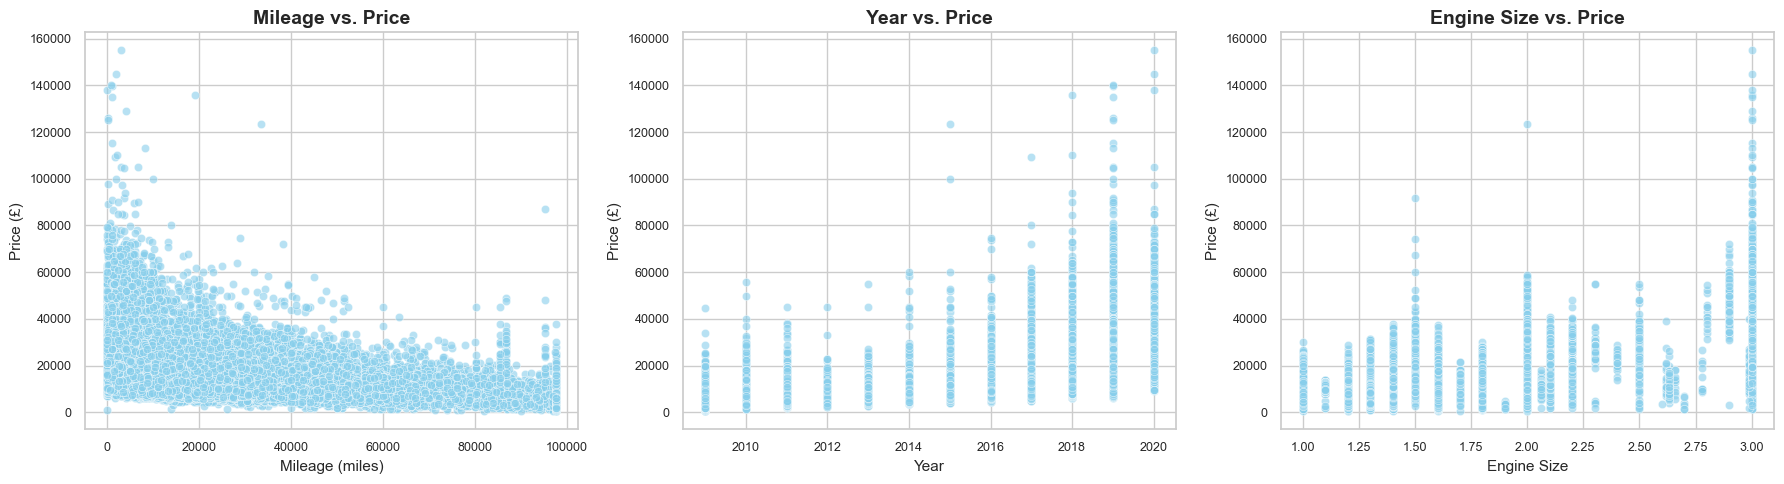

In [69]:

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

variables = ['mileage', 'year', 'engineSize']
titles = ['Mileage vs. Price', 'Year vs. Price', 'Engine Size vs. Price']
xlabels = ['Mileage (miles)', 'Year', 'Engine Size']

for i, (var, title, xlabels) in enumerate(zip(variables, titles, xlabels)):
    sns.scatterplot( data=X_train, x=var, y=y_train, ax=axes[i], alpha=0.6, color='skyblue' )
    
    axes[i].set_title(title, fontsize=14, fontweight='bold')
    axes[i].set_xlabel(xlabels, fontsize=11)
    axes[i].set_ylabel('Price (£)', fontsize=11)
    axes[i].tick_params(axis='both', labelsize=9)

plt.tight_layout()
plt.show()

Now, the scatter plots are not as noisy and the tendency between mileage, year, engine size and the target variable (price) is clearer.

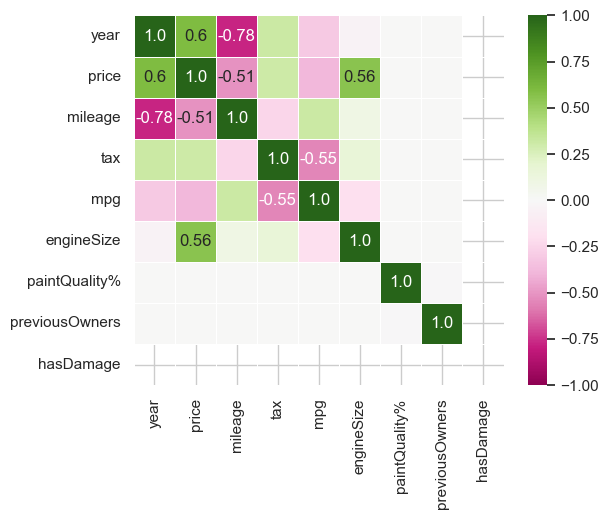

In [70]:

mask_annot = np.absolute(corr.values) >= 0.5 
annot = np.where(mask_annot, 
                 np.round(corr.values, 2),  
                 np.full(corr.shape, ""))


sns.heatmap(data=corr, 
            annot=annot,
            fmt='', 
            vmin=-1, vmax=1, 
            center=0,
            square=True,
            linewidths=.5,
            cmap='PiYG'
            )

plt.show()




<h3 style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> Missing Values Treatment </strong>
</h3>

<h3 style="background-color: #c9e8d0ff; color: #449e54ff; padding: 5px; margin: 5px;">
    <strong> Brand </strong>
</h3>

In [71]:
X_train["Brand_cleaned"].isnull().sum()

np.int64(1017)

In [72]:
X_val["Brand_cleaned"].isnull().sum()

np.int64(504)

To account for missing values in both Brand and Model we are going to impute the Brand as the mode of all the data set and impute the Model in the following section.

In [73]:
brand_mode = X_train['Brand_cleaned'].mode().iloc[0]

In [74]:
model_to_brand = (
    X_train.dropna(subset=['Brand_cleaned', 'model_cleaned'])
      .groupby('model_cleaned')['Brand_cleaned']
      .agg(lambda x: x.mode().iloc[0])  # get most frequent brand for each model
      .to_dict()
)

def impute_brand(row, mapping, global_mode):

    """
    Imputes missing values in the 'Brand_cleaned' column based on a model-to-brand mapping or a global mode value.

    The function checks a single row of a DataFrame:
    1. If 'Brand_cleaned' is missing (NaN):
       - If 'model_cleaned' exists and is present in 'mapping', it returns the corresponding brand.
       - Otherwise, it returns 'global_mode'.
    2. If 'Brand_cleaned' is not missing, it returns the existing value.

    Parameters
    ----------
    row : pandas.Series
        Represents an individual row in a pandas DataFrame.
    
    mapping : dict
        Dictionary mapping cleaned model names to their corresponding brand.
    
    global_mode : str
        The global most frequent brand value, used as an alternative for missing data.

    Returns
    -------
    str
        The imputed brand value for the row.
    """

    if pd.isna(row['Brand_cleaned']):
        if pd.notna(row['model_cleaned']) and row['model_cleaned'] in mapping:
            return mapping[row['model_cleaned']]
        else:
            return global_mode
    return row['Brand_cleaned']
    
X_train['Brand_cleaned'] = X_train.apply(lambda row: impute_brand(row, model_to_brand, brand_mode), axis=1)
X_val['Brand_cleaned'] = X_val.apply(lambda row: impute_brand(row, model_to_brand, brand_mode), axis=1)
df_test['Brand_cleaned'] = df_test.apply(lambda row: impute_brand(row, model_to_brand, brand_mode), axis=1)

In [75]:
X_train['Brand_cleaned'].isnull().sum()

np.int64(0)

In [76]:
X_val["Brand_cleaned"].isnull().sum()

np.int64(0)

In [77]:
df_test["Brand_cleaned"].isnull().sum()

np.int64(0)

<h3 style="background-color: #c9e8d0ff; color: #449e54ff; padding: 5px; margin: 5px;">
    <strong> Model </strong>
</h3>

In [78]:
X_train['model_cleaned'].isnull().sum()

np.int64(1202)

In [79]:
X_val['model_cleaned'].isnull().sum()

np.int64(517)

In [80]:
def build_model_mappings(df):

    """
    Builds multiple mappings for imputing car models based on available specifications.

    This function creates several mappings of varying detail, which can be used to impute missing values in the 'model_cleaned' column based on combinations of other features.
    Each mapping uses the model's mode for the given feature combination.

    The mappings are built in decreasing order of detail:
    - mapping_5: Uses Brand, Fuel Type, Engine Size, and Transmission.
    - mapping_4: Uses Brand, Fuel Type, and Engine Size.
    - mapping_3: Uses Brand and Fuel Type.
    - mapping_2: Uses Brand and Transmission.
    - mapping_1: Uses Brand and Engine Size.

    Parameters
    ----------
    df : pandas.DataFrame
        containing the columns 'Brand_cleaned', 'model_cleaned', 'fuelType_cleaned','engineSize', and 'transmission_cleaned'.

    Returns
    -------
    mapping_5, mapping_4, mapping_3, mapping_2, mapping_1 : dict
        Five dictionaries mapping combinations of features to the most frequent model name.
    """

    mapping_5 = (
        df.dropna(subset=['Brand_cleaned', 'model_cleaned', 'fuelType_cleaned', 'engineSize', 'transmission_cleaned'])
          .groupby(['Brand_cleaned', 'fuelType_cleaned', 'engineSize', 'transmission_cleaned'])['model_cleaned']
          .agg(lambda x: x.mode().iloc[0]).to_dict()
    )
    mapping_4 = (
        df.dropna(subset=['Brand_cleaned', 'model_cleaned', 'fuelType_cleaned', 'engineSize'])
          .groupby(['Brand_cleaned', 'fuelType_cleaned', 'engineSize'])['model_cleaned']
          .agg(lambda x: x.mode().iloc[0]).to_dict()
    )
    mapping_3 = (
        df.dropna(subset=['Brand_cleaned', 'model_cleaned', 'fuelType_cleaned'])
          .groupby(['Brand_cleaned', 'fuelType_cleaned'])['model_cleaned']
          .agg(lambda x: x.mode().iloc[0]).to_dict()
    )
    mapping_2 = (
        df.dropna(subset=['Brand_cleaned', 'model_cleaned', 'transmission_cleaned'])
          .groupby(['Brand_cleaned', 'transmission_cleaned'])['model_cleaned']
          .agg(lambda x: x.mode().iloc[0]).to_dict()
    )
    mapping_1 = (
        df.dropna(subset=['Brand_cleaned', 'model_cleaned', 'engineSize'])
          .groupby(['Brand_cleaned', 'engineSize'])['model_cleaned']
          .agg(lambda x: x.mode().iloc[0]).to_dict()
    )

    return mapping_5, mapping_4, mapping_3, mapping_2, mapping_1

In [81]:
def impute_model_flexible(row, maps):

    """
    Imputes missing 'model_cleaned' values using hierarchical mappings of varying detail.

    The function attempts to fill missing model values in a flexible way:
    1. It first tries the most specific mapping (mapping_5) that uses Brand, Fuel Type, Engine Size, and Transmission.
    2. If no match is found, it proceeds to less detailed mappings in the following order:
       mapping_4, mapping_3, mapping_2, mapping_1.
    3. If no mapping contains a match, the original model value is returned.

    Parameters
    ----------
    row : pandas.Series
        Represents an individual row in a pandas DataFrame.
    
    maps : tuple
        A tuple containing five dictionaries (mapping_5, mapping_4, mapping_3, mapping_2, mapping_1).

    Returns
    -------
    str
        The imputed model name if a match is found in any mapping, or the original 'model_cleaned' value if no match is found.
    """
    
    mapping_5, mapping_4, mapping_3, mapping_2, mapping_1 = maps

    # Try the most specific match first
    key5 = (row['Brand_cleaned'], row['fuelType_cleaned'], row['engineSize'], row['transmission_cleaned'])
    key4 = (row['Brand_cleaned'], row['fuelType_cleaned'], row['engineSize'])
    key3 = (row['Brand_cleaned'], row['fuelType_cleaned'])
    key2 = (row['Brand_cleaned'], row['transmission_cleaned'])
    key1 = (row['Brand_cleaned'], row['engineSize'])

    if pd.isna(row['model_cleaned']):
        if key5 in mapping_5: return mapping_5[key5]
        if key4 in mapping_4: return mapping_4[key4]
        if key3 in mapping_3: return mapping_3[key3]
        if key2 in mapping_2: return mapping_2[key2]
        if key1 in mapping_1: return mapping_1[key1]
    return row['model_cleaned']

In [82]:
maps = build_model_mappings(X_train)
X_train['model_cleaned'] = X_train.apply(lambda row: impute_model_flexible(row, maps), axis=1)
X_val['model_cleaned'] = X_val.apply(lambda row: impute_model_flexible(row, maps), axis=1)
df_test['model_cleaned'] = df_test.apply(lambda row: impute_model_flexible(row, maps), axis=1)

In [83]:
X_train['model_cleaned'].isnull().sum()

np.int64(0)

In [84]:
X_val['model_cleaned'].isnull().sum()

np.int64(0)

In [85]:
df_test['model_cleaned'].isnull().sum()

np.int64(0)

<h3 style="background-color: #c9e8d0ff; color: #449e54ff; padding: 5px; margin: 5px;">
    <strong> Year </strong>
</h3>

In [86]:
X_train['year'].isnull().sum()

np.int64(1274)

In [87]:
X_val['year'].isnull().sum()

np.int64(575)

For 'year', we are going to create bins of 'very low', 'low', 'average', 'high' and 'very high' mileage, and impute the median of each bin. To account for observations where both Year and Mileage are missing, we are going to impute the year based on the most correlated features (first tax, then mpg). If they are also missing, we will impute the median of 'year'.

In [88]:
# Create bins based on mileage quantiles
bins = X_train['mileage'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
labels = ['very low', 'low', 'average', 'high', 'very high']

X_train['mileage_bin'] = pd.cut(X_train['mileage'], bins=bins, labels=labels, include_lowest=True)
X_val['mileage_bin'] = pd.cut(X_val['mileage'], bins=bins, labels=labels, include_lowest=True)
df_test['mileage_bin'] = pd.cut(df_test['mileage'], bins=bins, labels=labels, include_lowest=True)

In [89]:
year_median = X_train['year'].median()

In [90]:
year_map_mileage = (
    X_train.dropna(subset=['year', 'mileage_bin'])
      .groupby('mileage_bin')['year']
      .median()
      .to_dict()
)
year_map_tax = (
    X_train.dropna(subset=['year', 'tax'])
      .groupby('tax')['year']
      .median()
      .to_dict()
)
year_map_mpg = (
    X_train.dropna(subset=['year', 'mpg'])
      .groupby('mpg')['year']
      .median()
      .to_dict()
)

In [91]:
def impute_year(row, map_mileage, map_tax, map_mpg, global_median):

    """
    Imputes missing 'year' values based on related features or a global median.

    The function checks a single row and attempts to fill missing 'year' values in the following order:
    1. If 'mileage_bin' exists and is in 'map_mileage', returns the mapped year.
    2. Else if 'tax' exists and is in 'map_tax', returns the mapped year.
    3. Else if 'mpg' exists and is in 'map_mpg', returns the mapped year.
    4. If none of the above conditions are met, returns 'global_median' as a fallback.
    5. If 'year' is not missing, it returns the original value.

    Parameters
    ----------
    row : pandas.Series
        Represents an individual row in a pandas DataFrame.

    map_mileage : dict
        Dictionary mapping mileage bins to the year's median within each bin.

    map_tax : dict
        Dictionary mapping tax values to the year's median within each bin.

    map_mpg : dict
        Dictionary mapping mpg values to the year's median within each bin.

    global_median : float
        The global median year.

    Returns
    -------
    float
        The imputed year for the row.
    """

    if pd.isna(row['year']):
        if pd.notna(row['mileage_bin']) and row['mileage_bin'] in map_mileage:
            return map_mileage[row['mileage_bin']]
        
        elif pd.notna(row['tax']) and row['tax'] in map_tax:
            return map_tax[row['tax']]
        
        elif pd.notna(row['mpg']) and row['mpg'] in map_mpg:
            return map_mpg[row['mpg']]
        
        return global_median

    return row['year']

In [92]:
X_train['year'] = X_train.apply(lambda row: impute_year(row, year_map_mileage, year_map_tax, year_map_mpg, year_median), axis=1)
X_val['year'] = X_val.apply(lambda row: impute_year(row, year_map_mileage, year_map_tax, year_map_mpg, year_median), axis=1)
df_test['year'] = df_test.apply(lambda row: impute_year(row, year_map_mileage, year_map_tax, year_map_mpg, year_median), axis=1)

In [93]:
X_train['year'].isna().sum()

np.int64(0)

In [94]:
X_val['year'].isna().sum()

np.int64(0)

In [95]:
df_test['year'].isna().sum()

np.int64(0)

In [96]:
X_train.drop('mileage_bin', axis=1, inplace=True)
X_val.drop('mileage_bin', axis=1, inplace=True)
df_test.drop('mileage_bin', axis=1, inplace=True)

<h3 style="background-color: #c9e8d0ff; color: #449e54ff; padding: 5px; margin: 5px;">
    <strong> Mileage </strong>
</h3>

In [97]:
X_train['mileage'].isnull().sum()

np.int64(1317)

We are going to group the cars by 'year' and impute the median of each year.

In [98]:
mileage_map = (
    X_train.dropna(subset=['mileage','year'])
      .groupby(['year'])['mileage']
      .median()
      .to_dict()
)

In [99]:
def impute_mileage(row, mapping):

    """
    Imputes missing 'mileage' values based on the car's year using a precomputed mapping.

    The function checks a single row and fills missing mileage as follows:
    1. If 'mileage' is missing (NaN) and the 'year' exists in the 'mapping', it returns the
       corresponding value from the mapping.
    2. If 'mileage' is not missing, it returns the original value.

    Parameters
    ----------
    row : pandas.Series
        Represents an individual row in a pandas Data Frame.

    mapping : dict
        Dictionary mapping each year to a representative mileage (median).

    Returns
    -------
    float
        The imputed mileage for the row, or the original mileage if it is already present.
    """

    if pd.isna(row['mileage']) and row['year'] in mapping:
        return mapping[row['year']]
    return row['mileage']

In [100]:
X_train['mileage'] = X_train.apply(lambda row: impute_mileage(row, mileage_map), axis=1)
X_val['mileage'] = X_val.apply(lambda row: impute_mileage(row, mileage_map), axis=1)
df_test['mileage'] = df_test.apply(lambda row: impute_mileage(row, mileage_map), axis=1)

In [101]:
X_train['mileage'].isna().sum()

np.int64(0)

In [102]:
X_val['mileage'].isna().sum()

np.int64(0)

In [103]:
df_test['mileage'].isna().sum()

np.int64(0)

<h3 style="background-color: #c9e8d0ff; color: #449e54ff; padding: 5px; margin: 5px;">
    <strong> Tax </strong>
</h3>

In [104]:
X_train['tax'].isnull().sum()

np.int64(5749)

In [105]:
X_val['tax'].isnull().sum()

np.int64(2533)

For 'tax', we are going to group the cars by model and year and impute the median, as cars of the same model tend to have similar road tax values and the age of the car might also be a factor. For cars that are the only model in a certain year, we are going to impute the median of the model. If we don't have more observations of the same model we are trying to impute, we are going to use the median of the year.

In [106]:
def build_tax_mappings(df):

  """
    Builds hierarchical mappings to impute missing 'tax' values based on model and year.

    The function creates three mappings of decreasing detail for imputing missing tax values:
    1. mapping_3: Uses both 'model_cleaned' and 'year' to map to the median tax.
    2. mapping_2: Uses only 'model_cleaned' to map to the median tax.
    3. mapping_1: Uses only 'year' to map to the median tax.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame used as the basis for constructing the maps.

    Returns
    -------
    mapping_3, mapping_2, mapping_1 : dict
        Three dictionaries mapping feature combinations to the median tax value.
    """

  mapping_3 = (
      df.dropna(subset=['model_cleaned','year', 'tax'])
        .groupby(['model_cleaned', 'year'])['tax']
        .median().to_dict()
  )
  mapping_2 = (
      df.dropna(subset=['model_cleaned', 'tax'])
        .groupby(['model_cleaned'])['tax']
        .median().to_dict()
  )
  mapping_1 = (
      df.dropna(subset=['year', 'tax'])
        .groupby(['year'])['tax']
        .median().to_dict()
  )
  return mapping_3, mapping_2, mapping_1

In [107]:
def impute_tax(row, maps):

    """
    Imputes missing 'tax' values using hierarchical mappings of varying detail.

    The function checks a single row and fills missing tax values in the following order:
    1. If the combination of 'model_cleaned' and 'year' exists in mapping_3, it returns the median tax.
    2. Else if 'model_cleaned' exists in mapping_2, it returns the median tax for that model.
    3. Else if 'year' exists in mapping_1, it returns the median tax for that year.
    4. If tax is not missing, the original 'tax' value is returned.

    Parameters
    ----------
    row : pandas.Series
        Represents an individual row in a pandas Data Frame.
    
    maps : tuple
        A tuple containing three dictionaries (mapping_3, mapping_2, mapping_1).

    Returns
    -------
    float
        The imputed tax value for the row, or the original 'tax' value if its already present.
    """
    
    mapping_3, mapping_2, mapping_1 = maps

    key3 = (row['model_cleaned'], row['year'])
    key2 = (row['model_cleaned'])
    key1 = (row['year'])

    if pd.isna(row['tax']):
        if key3 in mapping_3: return mapping_3[key3]
        if key2 in mapping_2: return mapping_2[key2]
        if key1 in mapping_1: return mapping_1[key1]
    return row['tax']

In [108]:
maps = build_tax_mappings(X_train)
X_train['tax'] = X_train.apply(lambda row: impute_tax(row, maps), axis=1)
X_val['tax'] = X_val.apply(lambda row: impute_tax(row, maps), axis=1)
df_test['tax'] = df_test.apply(lambda row: impute_tax(row, maps), axis=1)

In [109]:
X_train['tax'].isnull().sum()

np.int64(0)

In [110]:
X_val['tax'].isnull().sum()

np.int64(0)

In [111]:
df_test['tax'].isnull().sum()

np.int64(0)

<h3 style="background-color: #c9e8d0ff; color: #449e54ff; padding: 5px; margin: 5px;">
    <strong> fuelType </strong>
</h3>

In [112]:
X_train['fuelType_cleaned'].isnull().sum()

np.int64(1061)

In [113]:
X_val['fuelType_cleaned'].isnull().sum()

np.int64(450)

We are going to group the cars by model and impute the mode of the fuelType for each model.

In [114]:
def build_fuel_mappings(df):

    """
    Builds hierarchical mappings to impute missing 'fuelType_cleaned' values based on model or brand.

    The function creates two mappings for imputing missing fuel type values:
    1. mapping_2: Uses 'model_cleaned' to map to the most frequent fuel type for that model.
    2. mapping_1: Uses 'Brand_cleaned' to map to the most frequent fuel type for that brand.

    Parameters
    ----------
    df : pandas.DataFrame
        The Data Frame used as the basis for constructing the maps.

    Returns
    -------
    mapping_2, mapping_1 : dict
        Two dictionaries mapping features to the most frequent fuel type. 
    """

    mapping_2 = (
        df.dropna(subset=['model_cleaned','fuelType_cleaned'])
          .groupby(['model_cleaned'])['fuelType_cleaned']
          .agg(lambda x: x.mode().iloc[0]).to_dict()
    )
    mapping_1 = (
        df.dropna(subset=['Brand_cleaned', 'fuelType_cleaned'])
          .groupby(['Brand_cleaned'])['fuelType_cleaned']
          .agg(lambda x: x.mode().iloc[0]).to_dict()
    )
    return mapping_2, mapping_1

In [115]:
def impute_fueltype(row, maps):

    """
    Imputes missing 'fuelType_cleaned' values using hierarchical mappings of varying detail.

    The function checks a single row and fills missing fuel type values in the following order:
    1. If 'model_cleaned' exists in mapping_2, it returns the most frequent fuel type for that model.
    2. Else if 'Brand_cleaned' exists in mapping_1, it returns the most frequent fuel type for that brand.
    3. If fuelType is not missing, the original 'fuelType_cleaned' value is returned.

    Parameters
    ----------
    row : pandas.Series
        Represents an individual row in a pandas Data Frame.
    
    maps : tuple
        A tuple containing two dictionaries (mapping_2, mapping_1).

    Returns
    -------
    str
        The imputed fuel type for the row, or the original 'fuelType_cleaned' value if its already present.
    """

    mapping_2, mapping_1 = maps

    key2 = (row['model_cleaned'])
    key1 = (row['Brand_cleaned'])

    if pd.isna(row['fuelType_cleaned']):
        if key2 in mapping_2: return mapping_2[key2]
        if key1 in mapping_1: return mapping_1[key1]
    return row['fuelType_cleaned']

In [116]:
maps = build_fuel_mappings(X_train)
X_train['fuelType_cleaned'] = X_train.apply(lambda row: impute_fueltype(row, maps), axis=1)
X_val['fuelType_cleaned'] = X_val.apply(lambda row: impute_fueltype(row, maps), axis=1)
df_test['fuelType_cleaned'] = df_test.apply(lambda row: impute_fueltype(row, maps), axis=1)

In [117]:
X_train['fuelType_cleaned'].isna().sum()

np.int64(0)

In [118]:
X_val['fuelType_cleaned'].isna().sum()

np.int64(0)

In [119]:
df_test['fuelType_cleaned'].isna().sum()

np.int64(0)

<h3 style="background-color: #c9e8d0ff; color: #449e54ff; padding: 5px; margin: 5px;">
    <strong> mpg </strong>
</h3>

In [120]:
X_train['mpg'].isnull().sum()

np.int64(10927)

For 'mpg', we are going to group the cars by model and impute the median of each model, as cars of the same model tend to have the same mpg values. If there are no other cars from that model without NaN mpg, we will impute the median of the brand.

In [121]:
def build_mpg_mappings(df):

    """
    Builds hierarchical mappings to impute missing 'mpg' values based on model or brand.

    The function creates two mappings for imputing missing mpg values:
    1. mapping_2: Uses 'model_cleaned' to map to the median mpg for that model.
    2. mapping_1: Uses 'Brand_cleaned' to map to the median mpg for that brand.

    Parameters
    ----------
    df : pandas.DataFrame
        The Data Frame used as the basis for constructing the maps.

    Returns
    -------
    mapping_2, mapping_1 : dict
        Two dictionaries mapping features to the median mpg.
    """

    mapping_2 = (
        df.dropna(subset=['model_cleaned','mpg'])
          .groupby(['model_cleaned'])['mpg']
          .median().to_dict()
    )
    mapping_1 = (
        df.dropna(subset=['Brand_cleaned', 'mpg'])
          .groupby(['Brand_cleaned'])['mpg']
          .median().to_dict()
    )
    return mapping_2, mapping_1

In [122]:
def impute_mpg(row, maps):

    """
    Imputes missing 'mpg' values using hierarchical mappings of varying detail.

    The function checks a single row and fills missing mpg values in the following order:
    1. If 'model_cleaned' exists in mapping_2, it returns the median mpg for that model.
    2. Else if 'Brand_cleaned' exists in mapping_1, it returns the median mpg for that brand.
    3. If 'mpg' is not missing, the original 'mpg' value is returned.

    Parameters
    ----------
    row : pandas.Series
        Represents an individual row in a pandas Data Frame.
    
    maps : tuple
        A tuple containing two dictionaries (mapping_2, mapping_1).

    Returns
    -------
    float
        The imputed mpg value for the row, or the original 'mpg' value if its already present.
    """

    mapping_2, mapping_1 = maps

    key2 = (row['model_cleaned'])
    key1 = (row['Brand_cleaned'])

    if pd.isna(row['mpg']):
        if key2 in mapping_2: return mapping_2[key2]
        if key1 in mapping_1: return mapping_1[key1]
    return row['mpg']

In [123]:
maps = build_mpg_mappings(X_train)
X_train['mpg'] = X_train.apply(lambda row: impute_mpg(row, maps), axis=1)
X_val['mpg'] = X_val.apply(lambda row: impute_mpg(row, maps), axis=1)
df_test['mpg'] = df_test.apply(lambda row: impute_mpg(row, maps), axis=1)

In [124]:
X_train['mpg'].isnull().sum()

np.int64(0)

In [125]:
X_val['mpg'].isnull().sum()

np.int64(0)

In [126]:
df_test['mpg'].isnull().sum()

np.int64(0)

<h3 style="background-color: #c9e8d0ff; color: #449e54ff; padding: 5px; margin: 5px;">
    <strong> engineSize </strong>
</h3>

In [127]:
X_train['engineSize'].isnull().sum()

np.int64(1483)

In [128]:
X_val['engineSize'].isnull().sum()

np.int64(607)

We impute EngineSize based on the mode of the model. If there are no other cars from that model, we will impute the median of the brand.

In [129]:
def build_engine_mappings(df):

    """
    Builds hierarchical mappings to impute missing 'engineSize' values based on model or brand.

    The function creates two mappings for imputing missing engine size values:
    1. mapping_2: Uses 'model_cleaned' to map to the median engine size for that model.
    2. mapping_1: Uses 'Brand_cleaned' to map to the median engine size for that brand.

    Parameters
    ----------
    df : pandas.DataFrame
        The Data Frame used as basis for constructing the maps.

    Returns
    -------
    mapping_2, mapping_1 : dict
        Two dictionaries mapping features to the median engine size.
    """

    mapping_2 = (
        df.dropna(subset=['model_cleaned','engineSize'])
          .groupby(['model_cleaned'])['engineSize']
          .median().to_dict()
    )
    mapping_1 = (
        df.dropna(subset=['Brand_cleaned', 'engineSize'])
          .groupby(['Brand_cleaned'])['engineSize']
          .median().to_dict()
    )
    return mapping_2, mapping_1

In [130]:
def impute_engine(row, maps):

    """
    Imputes missing 'engineSize' values using hierarchical mappings of varying detail.

    The function checks a single row and fills missing engine size values in the following order:
    1. If 'model_cleaned' exists in mapping_2, it returns the median engine size for that model.
    2. Else if 'Brand_cleaned' exists in mapping_1, it returns the median engine size for that brand.
    3. If engineSize is not missing, the original 'engineSize' value is returned.

    Parameters
    ----------
    row : pandas.Series
        Represents an individual row in a Data Frame.
    
    maps : tuple
        A tuple containing two dictionaries (mapping_2, mapping_1).

    Returns
    -------
    float
        The imputed engine size for the row, or the original 'engineSize' value if the value its already present.
    """

    mapping_2, mapping_1 = maps

    key2 = (row['model_cleaned'])
    key1 = (row['Brand_cleaned'])

    if pd.isna(row['engineSize']):
        if key2 in mapping_2: return mapping_2[key2]
        if key1 in mapping_1: return mapping_1[key1]
    return row['engineSize']

In [131]:
maps = build_engine_mappings(X_train)
X_train['engineSize'] = X_train.apply(lambda row: impute_engine(row, maps), axis=1)
X_val['engineSize'] = X_val.apply(lambda row: impute_engine(row, maps), axis=1)
df_test['engineSize'] = df_test.apply(lambda row: impute_engine(row, maps), axis=1)

In [132]:
X_train['engineSize'].isnull().sum()

np.int64(0)

In [133]:
X_val['engineSize'].isnull().sum()

np.int64(0)

In [134]:
df_test['engineSize'].isnull().sum()

np.int64(0)

<h3 style="background-color: #c9e8d0ff; color: #449e54ff; padding: 5px; margin: 5px;">
    <strong> paintQuality% </strong>
</h3>

In [135]:
X_train['paintQuality%'].isnull().sum()

np.int64(1353)

In [136]:
X_val['paintQuality%'].isnull().sum()

np.int64(538)

For 'paintQuality%', we are going to group the cars by model and year and impute the median, as age is a factor that affects paint quality and also different brands might have different paint durability.
For the cars that are the only model from a certain year, we can't get the median value of paintQuality% of other similar cars, therefore we will impute the median value of the year.

In [137]:
def build_paint_mappings(df):

    """
    Builds hierarchical mappings to impute missing 'paintQuality%' values based on model and year.

    The function creates two mappings of decreasing detail for imputing missing paint quality values:
    1. mapping_2: Uses 'model_cleaned' and 'year' to map to the median paint quality for that model and year.
    2. mapping_1: Uses 'year' to map to the median paint quality for that year.

    Parameters
    ----------
    df : pandas.DataFrame
        The Data Frame used as basis for constructig the maps.

    Returns
    -------
    mapping_2, mapping_1 : dict
        Two dictionaries mapping feature combinations to the median paint quality percentage. 
    """

    mapping_2 = (
        df.dropna(subset=['model_cleaned','year', 'paintQuality%'])
          .groupby(['model_cleaned', 'year'])['paintQuality%']
          .median().to_dict()
    )
    mapping_1 = (
        df.dropna(subset=['year', 'paintQuality%'])
          .groupby(['year'])['paintQuality%']
          .median().to_dict()
    )
    return mapping_2, mapping_1

In [138]:
def impute_paint(row, maps):

    """
    Imputes missing 'paintQuality%' values using hierarchical mappings of varying detail.

    The function checks a single row and fills missing paint quality values in the following order:
    1. If the combination of 'model_cleaned' and 'year' exists in mapping_2, it returns the median paint quality for that combination.
    2. Else if 'year' exists in mapping_1, it returns the median paint quality for that year.
    3. If paintQuality is not missing, the original 'paintQuality%' value is returned.

    Parameters
    ----------
    row : pandas.Series
        Represents an individual row in a Data Frame.
    
    maps : tuple
        A tuple containing two dictionaries (mapping_2, mapping_1).

    Returns
    -------
    float
        The imputed paint quality percentage for the row, or the original 'paintQuality%' value if the value is already present.
    """

    mapping_2, mapping_1 = maps

    key2 = (row['model_cleaned'], row['year'])
    key1 = (row['year'])

    if pd.isna(row['paintQuality%']):
        if key2 in mapping_2: return mapping_2[key2]
        if key1 in mapping_1: return mapping_1[key1]
    return row['paintQuality%']

In [139]:
maps = build_paint_mappings(X_train)
X_train['paintQuality%'] = X_train.apply(lambda row: impute_paint(row, maps), axis=1)
X_val['paintQuality%'] = X_val.apply(lambda row: impute_paint(row, maps), axis=1)
df_test['paintQuality%'] = df_test.apply(lambda row: impute_paint(row, maps), axis=1)

In [140]:
X_train['paintQuality%'].isna().sum()

np.int64(0)

In [141]:
X_val['paintQuality%'].isna().sum()

np.int64(0)

In [142]:
df_test['paintQuality%'].isna().sum()

np.int64(0)

<h3 style="background-color: #c9e8d0ff; color: #449e54ff; padding: 5px; margin: 5px;">
    <strong> previousOwners </strong>
</h3>

In [143]:
X_train['previousOwners'].isnull().sum()

np.int64(1386)

In [144]:
X_val['previousOwners'].isnull().sum()

np.int64(535)

For 'previousOwners', we are going to group the cars by model and year and impute the median, since older cars tend to have more owners and there are certain models more prone to resale, e.g., luxury cars don't usually have many owners. For the cars that are the only model from a certain year, we can't get the median value of 'previousOwners' of other similar cars, therefore we will impute the median value of the year.

In [145]:
def build_owners_mappings(df):

    """
    Builds hierarchical mappings to impute missing 'previousOwners' values based on model and year.

    The function creates two mappings of decreasing detail for imputing missing previous owners:
    1. mapping_2: Uses 'model_cleaned' and 'year' to map to the median number of previous owners for that combination.
    2. mapping_1: Uses 'year' to map to the median number of previous owners for that year.

    Parameters
    ----------
    df : pandas.DataFrame
        The Data Frame used as basis for constructing the maps.

    Returns
    -------
    mapping_2, mapping_1 : dict
        Two dictionaries mapping feature combinations to the median number of previous owners. 
    """

    mapping_2 = (
        df.dropna(subset=['model_cleaned','year', 'previousOwners'])
          .groupby(['model_cleaned', 'year'])['previousOwners']
          .median().to_dict()
    )
    mapping_1 = (
        df.dropna(subset=['year', 'previousOwners'])
          .groupby(['year'])['previousOwners']
          .median().to_dict()
    )
    return mapping_2, mapping_1

In [146]:
def impute_owners(row, maps):

    """
    Imputes missing 'previousOwners' values using hierarchical mappings of varying detail.

    The function checks a single row and fills missing previous owners values in the following order:
    1. If the combination of 'model_cleaned' and 'year' exists in mapping_2, it returns the median number of previous owners for that combination.
    2. Else if 'year' exists in mapping_1, it returns the median number of previous owners for that year.
    3. If previousOwners is not missing, the original 'previousOwners' value is returned.

    Parameters
    ----------
    row : pandas.Series
        Represents an individual row in a Data Frame.
    
    maps : tuple
        A tuple containing two dictionaries (mapping_2, mapping_1).

    Returns
    -------
    float
        The imputed number of previous owners for the row, or the original 'previousOwners' value if the value is already present.
    """

    mapping_2, mapping_1 = maps

    key2 = (row['model_cleaned'], row['year'])
    key1 = (row['year'])

    if pd.isna(row['previousOwners']):
        if key2 in mapping_2: return mapping_2[key2]
        if key1 in mapping_1: return mapping_1[key1]
    return row['previousOwners']

In [147]:
maps = build_owners_mappings(X_train)
X_train['previousOwners'] = X_train.apply(lambda row: impute_owners(row, maps), axis=1)
X_val['previousOwners'] = X_val.apply(lambda row: impute_owners(row, maps), axis=1)
df_test['previousOwners'] = df_test.apply(lambda row: impute_owners(row, maps), axis=1)

In [148]:
X_train['previousOwners'].isna().sum()

np.int64(0)

In [149]:
X_val['previousOwners'].isna().sum()

np.int64(0)

In [150]:
df_test['previousOwners'].isna().sum()

np.int64(0)

<h3 style="background-color: #c9e8d0ff; color: #449e54ff; padding: 5px; margin: 5px;">
    <strong> hasDamage </strong>
</h3>

In [151]:
X_train['hasDamage'].isnull().sum()

np.int64(0)

In [152]:
X_val['hasDamage'].isnull().sum()

np.int64(0)

<h3 style="background-color: #c9e8d0ff; color: #449e54ff; padding: 5px; margin: 5px;">
    <strong> Transmission </strong>
</h3>

In [153]:
X_train['transmission_cleaned'].isna().sum()

np.int64(1074)

In [154]:
X_val['transmission_cleaned'].isna().sum()

np.int64(448)

We impute transmission based on the mode of the model. If we don't have data for the car model, we will use the mode of the brand.

In [155]:
def build_transmission_mappings(df):

    """
    Builds hierarchical mappings to impute missing 'transmission_cleaned' values based on model or brand.

    The function creates two mappings for imputing missing transmission types:
    1. mapping_2: Uses 'model_cleaned' to map to the most frequent transmission for that model.
    2. mapping_1: Uses 'Brand_cleaned' to map to the most frequent transmission for that brand.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame used as basis for constructing the maps.

    Returns
    -------
    mapping_2, mapping_1 : dict
        Two dictionaries mapping features to the most frequent transmission type. 
    """

    mapping_2 = (
        df.dropna(subset=['model_cleaned','transmission_cleaned'])
          .groupby(['model_cleaned'])['transmission_cleaned']
          .agg(lambda x: x.mode().iloc[0]).to_dict()
    )
    mapping_1 = (
        df.dropna(subset=['Brand_cleaned', 'transmission_cleaned'])
          .groupby(['Brand_cleaned'])['transmission_cleaned']
          .agg(lambda x: x.mode().iloc[0]).to_dict()
    )
    return mapping_2, mapping_1

In [156]:
def impute_transmission(row, maps):

    """
    Imputes missing 'transmission_cleaned' values using hierarchical mappings of varying detail.

    The function checks a single row and fills missing transmission values in the following order:
    1. If 'model_cleaned' exists in mapping_2, it returns the most frequent transmission for that model.
    2. Else if 'Brand_cleaned' exists in mapping_1, it returns the most frequent transmission for that brand.
    3. If transmission is not missing, the original 'transmission_cleaned' value is returned.

    Parameters
    ----------
    row : pandas.Series
        Represents an individual row in a pandas Data Frame.
    
    maps : tuple
        A tuple containing two dictionaries (mapping_2, mapping_1).
    Returns
    -------
    str
        The imputed transmission value for the row, or the original 'transmission_cleaned' value if the value is already present.
    """

    mapping_2, mapping_1 = maps

    key2 = (row['model_cleaned'])
    key1 = (row['Brand_cleaned'])

    if pd.isna(row['transmission_cleaned']):
        if key2 in mapping_2: return mapping_2[key2]
        if key1 in mapping_1: return mapping_1[key1]
    return row['transmission_cleaned']

In [157]:
maps = build_transmission_mappings(X_train)
X_train['transmission_cleaned'] = X_train.apply(lambda row: impute_transmission(row, maps), axis=1)
X_val['transmission_cleaned'] = X_val.apply(lambda row: impute_transmission(row, maps), axis=1)
df_test['transmission_cleaned'] = df_test.apply(lambda row: impute_transmission(row, maps), axis=1)

In [158]:
X_train['transmission_cleaned'].isna().sum()

np.int64(0)

In [159]:
X_val['transmission_cleaned'].isna().sum()

np.int64(0)

In [160]:
df_test['transmission_cleaned'].isna().sum()

np.int64(0)

<h3 style="background-color: #c9e8d0ff; color: #449e54ff; padding: 5px; margin: 5px;">
    <strong> Typecasting </strong>
</h3>

After filling in the mssing values values we can typecast 'year' and 'previousOwners' into integers.

In [161]:
X_train['year'] = X_train['year'].astype(int)
X_val['year'] = X_val['year'].astype(int)
df_test['year'] = df_test['year'].astype(int)

X_train['previousOwners'] = X_train['previousOwners'].astype(int)
X_val['previousOwners'] = X_val['previousOwners'].astype(int)
df_test['previousOwners'] = df_test['previousOwners'].astype(int)

In [162]:
print('Dtypes:\n\n', X_train.dtypes)
print('\n', X_train.head())

Dtypes:

 Brand                    object
model                    object
year                      int64
transmission             object
mileage                 float64
fuelType                 object
tax                     float64
mpg                     float64
engineSize              float64
paintQuality%           float64
previousOwners            int64
hasDamage                  bool
Brand_cleaned            object
transmission_cleaned     object
fuelType_cleaned         object
model_cleaned            object
dtype: object

           Brand      model  year transmission  mileage fuelType    tax   mpg  \
carID                                                                          
42904  MERCEDES  CLS CLASS  2017     SEMI-AUT  30000.0   DIESEL  165.0  51.4   
65965        VW     TIGUAN  2019          NaN  12101.0   DIESEL  150.0  49.6   
69226        VW     PASSAT  2018    AUTOMATIC   4429.0   PETROL  145.0  48.7   
36037  MERCEDES  GLC CLASS  2019    SEMI-AUTO   5649.0   DIESE

<h3 style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> Feature Engineering </strong>
</h3>

#### *New features*

- **Brand_model** : Brand_model 
     - The model carries the brand information.
- **carAge** : The age of the car. 
     - It contains the same information as the year, but its interpretation is more straightforward.
- **AvgUsage** : Shows average usage.
    - Total mileage is not comparable between cars of different ages.
- **logPrice**: logarithm of the price.
    - The price tends to be log-normal, and linear regression handles log-transforms better.
    - We will try to run the model with price and logPrice and see which one gives better results.

In [163]:
X_train['Brand_model'] = X_train ['Brand_cleaned'] + '_' + X_train ['model_cleaned']
X_val['Brand_model'] = X_val ['Brand_cleaned'] + '_' + X_val ['model_cleaned']
df_test['Brand_model'] = df_test ['Brand_cleaned'] + '_' + df_test ['model_cleaned']

X_train['carAge'] = (2020 - X_train['year']).round(0).astype(int) #0 means it's from 2020
X_val['carAge'] = (2020 - X_val['year']).round(0).astype(int)
df_test['carAge'] = (2020 - df_test['year']).round(0).astype(int)

X_train['AvgUsage'] = X_train['mileage'] / (X_train ['carAge'] +1) #+1 to avoid divisions by 0
X_val['AvgUsage'] = X_val['mileage'] / (X_val ['carAge'] +1)
df_test['AvgUsage'] = df_test['mileage'] / (df_test ['carAge'] +1)

y_train_experiment = np.log1p(y_train) #+1 to log(0)
y_val_experiment = np.log1p(y_val)

X_train.head()

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,Brand_cleaned,transmission_cleaned,fuelType_cleaned,model_cleaned,Brand_model,carAge,AvgUsage
carID,,,,,,,,,,,,,,,,,,,
42904,MERCEDES,CLS CLASS,2017,SEMI-AUT,30000.0,DIESEL,165.0,51.4,3.0,86.0,4,False,MERCEDES,SEMI-AUTO,DIESEL,CLS CLASS,MERCEDES_CLS CLASS,3,7500.000000
65965,VW,TIGUAN,2019,NaN,12101.0,DIESEL,150.0,49.6,2.0,49.0,0,False,VW,MANUAL,DIESEL,TIGUAN,VW_TIGUAN,1,6050.500000
69226,VW,PASSAT,2018,AUTOMATIC,4429.0,PETROL,145.0,48.7,1.8,92.0,1,False,VW,AUTOMATIC,PETROL,PASSAT,VW_PASSAT,2,1476.333333
36037,MERCEDES,GLC CLASS,2019,SEMI-AUTO,5649.0,DIESEL,145.0,44.8,2.0,31.0,4,False,MERCEDES,SEMI-AUTO,DIESEL,GLC CLASS,MERCEDES_GLC CLASS,1,2824.500000
1129,AUDI,A5,2019,SEMI-AUTO,1475.0,PETROL,145.0,52.3,2.0,93.0,0,False,AUDI,SEMI-AUTO,PETROL,A5,AUDI_A5,1,737.500000


In [164]:
for feat in ['Brand_model', 'carAge', 'AvgUsage']:
    print(f'{feat}:')
    print(X_train[feat].isna().sum())
    print(X_val[feat].isna().sum())
    print(df_test[feat].isna().sum())

Brand_model:
0
0
0
carAge:
0
0
0
AvgUsage:
0
0
0


#### *Encoding categorical variables*

When using Feature Encoders, it is important to remember that only the training data should be used to fit the encoder.

- Feature Encoders: https://medium.com/@pedrorp/guia-de-codificadores-de-atributos-categ%C3%B3ricos-em-machine-learning-60a9f22c9a3b

-----------------------------------------------------------------------------------------------------

We decided to use **Target Encoding** for models, Brand_model and Brand, due to the large number of categories.
This type of encoding can improve model performance by incorporating target information directly into the feature. Also, it does not increase the input space.
This encoder calculates the average of the target variable for each category (using only the training data).

For the other variables we'll use **One-hot Encoding**.

In [165]:
target_features = ['model_cleaned', 'Brand_model','Brand_cleaned']
one_hot_features = ['fuelType_cleaned', 'transmission_cleaned']

In [166]:
encoder = TargetEncoder(categories="auto" , target_type="continuous" ) 

encoder.fit(X_train[target_features], y_train)

X_train[[f'{feat}_encoded' for feat in target_features]] = encoder.transform(X_train[target_features])
X_val[[f'{feat}_encoded' for feat in target_features]] = encoder.transform(X_val[target_features])
df_test[[f'{feat}_encoded' for feat in target_features]] = encoder.transform(df_test[target_features])

In [167]:
for feat in one_hot_features:
    encoder = OneHotEncoder(drop='first', categories="auto" , handle_unknown="ignore", sparse_output=False).set_output(transform='pandas')
    encoder.fit(X_train[[feat]])

    train = encoder.transform(X_train[[feat]])
    val = encoder.transform(X_val[[feat]])
    test = encoder.transform(df_test[[feat]])

    X_train = pd.concat ([X_train, train], axis=1)
    X_val = pd.concat ([X_val, val], axis=1)
    df_test =pd.concat ([df_test, test], axis=1)

<h3 style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> Scaling </strong>
</h3>

In [168]:
numeric_features = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',	'previousOwners', 'carAge', 'AvgUsage',
                    'model_cleaned_encoded', 'Brand_model_encoded', 'Brand_cleaned_encoded']

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
df_test_scaled = df_test.copy()

scaler = StandardScaler()

scaler.fit(X_train_scaled[numeric_features])

X_train_scaled[numeric_features] = scaler.transform(X_train_scaled[numeric_features])
X_val_scaled[numeric_features] = scaler.transform(X_val_scaled[numeric_features])
df_test_scaled[numeric_features] = scaler.transform(df_test_scaled[numeric_features])

In [169]:
X_train_scaled.head()

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,...,Brand_model_encoded,Brand_cleaned_encoded,fuelType_cleaned_ELECTRIC,fuelType_cleaned_HYBRID,fuelType_cleaned_OTHER,fuelType_cleaned_PETROL,transmission_cleaned_MANUAL,transmission_cleaned_OTHER,transmission_cleaned_SEMI-AUTO,transmission_cleaned_UNKNOWN
carID,,,,,,,,,,,,,,,,,,,,,
42904,MERCEDES,CLS CLASS,-0.048970,SEMI-AUT,0.336529,DIESEL,0.737499,-0.597089,2.604060,1.062388,...,1.559822,1.452509,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
65965,VW,TIGUAN,0.936003,NaN,-0.533377,DIESEL,0.490907,-0.784640,0.661415,-0.751317,...,0.646898,0.004057,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
69226,VW,PASSAT,0.443517,AUTOMATIC,-0.906242,PETROL,0.408710,-0.878416,0.272885,1.356503,...,-0.023975,0.004057,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36037,MERCEDES,GLC CLASS,0.936003,SEMI-AUTO,-0.846949,DIESEL,0.408710,-1.284777,0.661415,-1.633661,...,2.179202,1.452509,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1129,AUDI,A5,0.936003,SEMI-AUTO,-1.049808,PETROL,0.408710,-0.503313,0.661415,1.405522,...,0.952313,1.134662,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


<h3 style="background-color: #bdfeb6ff; color: #449e54ff; padding: 5px; margin: 5px;">
  <strong> Feature Selection </strong>
</h3>

### **Drop uncorrected and uncoded variables**

First, lets drop the variables without corrections and the uncoded categorical variables. 

We'll keep all variables in X_train, X_val, and df_test because we might need to make some kind of comparison with the original data in the future. We'll just remove variables from the already scaled datasets: X_train_scaled, X_val_scaled, df_test_scaled. 

In [170]:
X_train_scaled.drop(['Brand', 'model', 'transmission', 'fuelType','Brand_cleaned', 'transmission_cleaned', 'fuelType_cleaned',
                     'model_cleaned', 'Brand_model'], axis=1, inplace=True)
X_val_scaled.drop(['Brand', 'model', 'transmission', 'fuelType','Brand_cleaned', 'transmission_cleaned', 'fuelType_cleaned',
                     'model_cleaned', 'Brand_model'], axis=1, inplace=True)
df_test_scaled.drop(['Brand', 'model', 'transmission', 'fuelType','Brand_cleaned', 'transmission_cleaned', 'fuelType_cleaned',
                     'model_cleaned', 'Brand_model'], axis=1, inplace=True)
X_train_scaled.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,carAge,AvgUsage,...,Brand_model_encoded,Brand_cleaned_encoded,fuelType_cleaned_ELECTRIC,fuelType_cleaned_HYBRID,fuelType_cleaned_OTHER,fuelType_cleaned_PETROL,transmission_cleaned_MANUAL,transmission_cleaned_OTHER,transmission_cleaned_SEMI-AUTO,transmission_cleaned_UNKNOWN
carID,,,,,,,,,,,,,,,,,,,,,
42904,-0.048970,0.336529,0.737499,-0.597089,2.604060,1.062388,1.391846,False,0.048970,0.546568,...,1.559822,1.452509,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
65965,0.936003,-0.533377,0.490907,-0.784640,0.661415,-0.751317,-1.417626,False,-0.936003,0.177663,...,0.646898,0.004057,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
69226,0.443517,-0.906242,0.408710,-0.878416,0.272885,1.356503,-0.715258,False,-0.443517,-0.986483,...,-0.023975,0.004057,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36037,0.936003,-0.846949,0.408710,-1.284777,0.661415,-1.633661,1.391846,False,-0.936003,-0.643368,...,2.179202,1.452509,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1129,0.936003,-1.049808,0.408710,-0.503313,0.661415,1.405522,-1.417626,False,-0.936003,-1.174519,...,0.952313,1.134662,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### **Filter methods**

We already know from the various plots made so far that there are no constant variables, but one way to verify this is to calculate the variance of each one.

We use X_train because StandardScaler defines the variance as 1.

In [171]:
X_train.select_dtypes(include=np.number).var()

year                              4.123057e+00
mileage                           4.233717e+08
tax                               3.700263e+03
mpg                               9.211136e+01
engineSize                        2.649848e-01
paintQuality%                     4.161769e+02
previousOwners                    2.027117e+00
carAge                            4.123057e+00
AvgUsage                          1.543893e+07
model_cleaned_encoded             5.184147e+07
Brand_model_encoded               5.184485e+07
Brand_cleaned_encoded             2.707868e+07
fuelType_cleaned_ELECTRIC         7.521059e-05
fuelType_cleaned_HYBRID           2.914597e-02
fuelType_cleaned_OTHER            2.120344e-03
fuelType_cleaned_PETROL           2.471839e-01
transmission_cleaned_MANUAL       2.462157e-01
transmission_cleaned_OTHER        5.640900e-05
transmission_cleaned_SEMI-AUTO    1.757504e-01
transmission_cleaned_UNKNOWN      9.387431e-03
dtype: float64

In [172]:
X_train_scaled ['hasDamage_num'] = X_train_scaled['hasDamage'].astype(int)

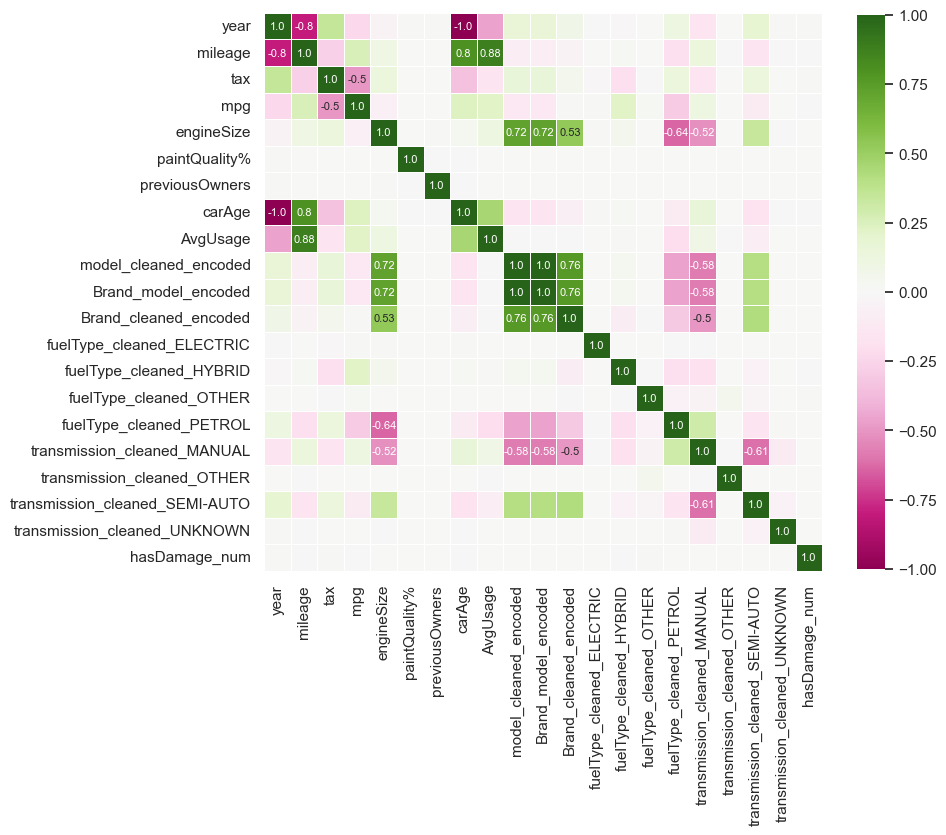

In [173]:
corr = X_train_scaled.select_dtypes(include=np.number).corr(method="spearman").round(2)

mask_annot = np.absolute(corr.values) >= 0.5 
annot = np.where(mask_annot, 
                 np.round(corr.values, 2),  
                 np.full(corr.shape, ""))

plt.figure(figsize=(9,8))
sns.heatmap(data=corr, 
            annot=annot,
            fmt='', 
            vmin=-1, vmax=1, 
            center=0,
            square=True,
            linewidths=.5,
            cmap='PiYG', 
            cbar_kws={"shrink": 0.9},  
            annot_kws={"size":8}
            )

plt.show()

Regarding the correlations: 

- As expected year and carAge are perfectly correlated. We'll probably drop year because carAge is easier to interpret.

- Brand_model and model are also perfectly correlated. Their correlation with Brand is high (aprox 0.8). The goal in creating Brand_model was to compile information about both the brand and the model, so we'll probably keep Brand_model and drop the other two.

- mileage is highly correlated with carAge (0.8) and AvgUsage (0.88). We'll probably keep carAge and AvgUsage. This way, we don't remove relevant information, since AvgUsage measures mileage per year, and the two variables maintained don't show a high correlation, which is ideal.

- We can see that whether a car is manual or not is correlated (~0.6) with the car model, which makes sense.

One note regarding previously categorical variables: the Chi-square test was performed before encoding and feature engineering, and the results are consistent with those obtained after encoding.

Brand_model_encoded               0.779530
model_cleaned_encoded             0.779469
carAge                           -0.596872
year                              0.596872
transmission_cleaned_MANUAL      -0.593175
Brand_cleaned_encoded             0.578864
engineSize                        0.574271
mileage                          -0.520133
transmission_cleaned_SEMI-AUTO    0.443828
AvgUsage                         -0.335674
tax                               0.316024
fuelType_cleaned_PETROL          -0.276342
mpg                              -0.249742
fuelType_cleaned_HYBRID           0.073924
fuelType_cleaned_OTHER            0.011512
previousOwners                    0.006122
transmission_cleaned_OTHER        0.004059
paintQuality%                     0.003721
hasDamage_num                     0.002136
fuelType_cleaned_ELECTRIC         0.001055
transmission_cleaned_UNKNOWN      0.000406
dtype: float64


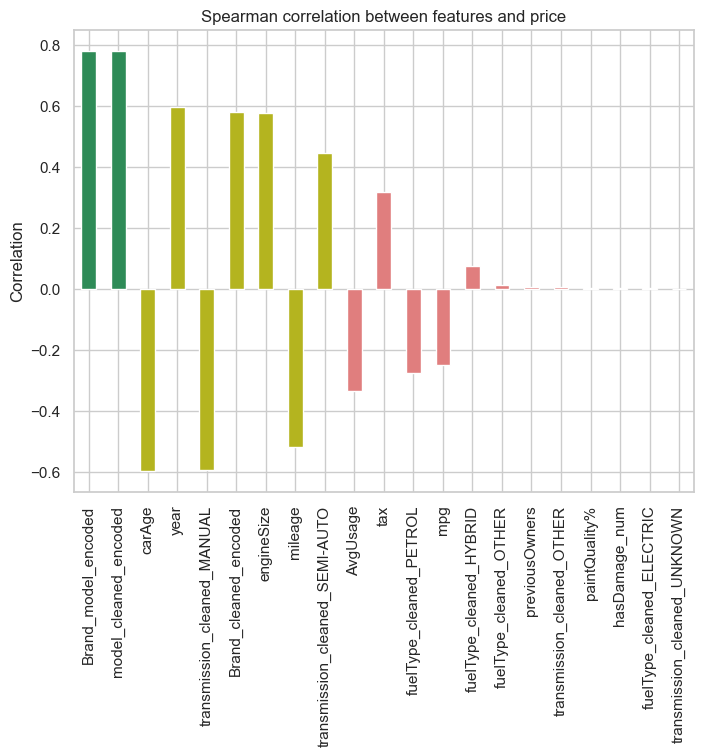

In [174]:
features = X_train_scaled.select_dtypes(include=np.number)
corr_with_price = features.apply(lambda x: x.corr(y_train, method='spearman')).sort_values(key=abs, ascending=False)
print(corr_with_price)

colors = []
for c in corr_with_price:
    if abs(c) >= 0.7:
        colors.append('#2E8B57')  #strong 
    elif abs(c) >= 0.4 and abs(c) <0.7:
        colors.append("#b4b41f")  #medium
    else:
        colors.append('#E07E7E')  #weak

plt.figure(figsize=(8,6))
corr_with_price.plot(kind='bar', color=colors)
plt.title('Spearman correlation between features and price')
plt.ylabel('Correlation')
plt.show()

Regarding the correlations:

- Brand_model and model are the most correlated with the target. We should keep one of them, since these two variables are perfectly correlated.
- carAge and year have the same absolute value. We'll also only keep just one of them.
- The correlations with paintQuality%, previous Owners and hasDamaged are also very low ( less than 0.01) so we should probably drop them.
- As for the one hot encoded variables, the categories that show a low correlation with price are probably not relevant. We could keep all of them or group all these categories into a single category. For now we'll choose the first option.

In [175]:
to_choose= ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'hasDamage', 'carAge', 'AvgUsage',
       'model_cleaned_encoded', 'Brand_model_encoded', 'Brand_cleaned_encoded']

In [176]:
X_train_aux = X_train_scaled[to_choose].copy()
X_val_aux = X_val_scaled[to_choose].copy()
df_test_aux = df_test_scaled[to_choose].copy()

In [177]:
X_train_scaled.drop('hasDamage_num', axis=1, inplace=True) 

### **Wrapper methods**

**Base estimator choice**: it's generally a good idea to use an estimator that is similar to the final model you intend to deploy. Since our target is continuous (price) the base estimator should be a regression model, not a classification model.

#### *Linear Regression*

In [178]:
nof_list = np.arange(1, len(X_train_aux.columns) + 1) #creates an array of integers from 1 to the total number of columns in X_train_scaled

high_score = 0 # Variable to store the highest validation score found
nof = 0 # Variable to store the optimum number of features  

# Lists to store training and validation scores
train_score_list = []
val_score_list = []

for n in range(len(nof_list)):
    model = LinearRegression() #base estimator
    
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    
    X_train_rfe = rfe.fit_transform(X_train_aux, y_train) # Fit RFE on the training set and return only the selected features
    
    X_val_rfe = rfe.transform(X_val_aux) # Apply the same feature selection to the validation set (transform only, no fit)
    
    model.fit(X_train_rfe, y_train) # Train the model with the selected features on the training set
    
    train_score = model.score(X_train_rfe, y_train) #R^2
    train_score_list.append(train_score)
    
    val_score = model.score(X_val_rfe, y_val) #R^2
    val_score_list.append(val_score)
    
    if val_score >= high_score:
        high_score = val_score  # Update the best score
        nof = nof_list[n]       # Update the optimum number of features
        features_to_select = pd.Series(rfe.support_, index = X_train_aux.columns)

print(f"Optimum number of features: {nof}")
print(f"Score with {nof} features: {high_score}")
print(f"Features to select:\n{features_to_select}")

Optimum number of features: 13
Score with 13 features: 0.789332845081614
Features to select:
year                     True
mileage                  True
tax                      True
mpg                      True
engineSize               True
paintQuality%            True
previousOwners           True
hasDamage                True
carAge                   True
AvgUsage                 True
model_cleaned_encoded    True
Brand_model_encoded      True
Brand_cleaned_encoded    True
dtype: bool


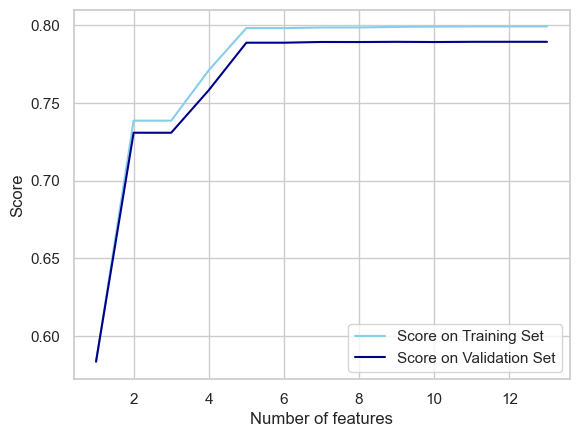

In [179]:
plt.plot(list(range(1,14)), train_score_list, label="Score on Training Set", color='skyblue')
plt.plot(list(range(1,14)), val_score_list, label="Score on Validation Set", color='darkblue')
plt.xlabel("Number of features")
plt.ylabel("Score")
plt.legend()
plt.show()

To maintain a balance between precision and complexity, we chose the number of features at which the score stabilizes: ~6 features.

In [180]:
model = LinearRegression()
rfe = RFE(estimator = model, n_features_to_select = 6)
X_rfe = rfe.fit_transform(X = X_train_aux, y = y_train)
selected_features = pd.Series(rfe.support_, index = X_train_aux.columns)
selected_features

year                      True
mileage                   True
tax                      False
mpg                      False
engineSize                True
paintQuality%            False
previousOwners           False
hasDamage                False
carAge                    True
AvgUsage                 False
model_cleaned_encoded     True
Brand_model_encoded       True
Brand_cleaned_encoded    False
dtype: bool

#### *LASSO*

In [181]:
nof_list = np.arange(1, len(X_train_aux.columns) + 1) #creates an array of integers from 1 to the total number of columns in X_train_scaled

high_score = 0 # Variable to store the highest validation score found
nof = 0 # Variable to store the optimum number of features  

# Lists to store training and validation scores
train_score_list = []
val_score_list = []

for n in range(len(nof_list)):
    model = Lasso() #base estimator
    
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    
    X_train_rfe = rfe.fit_transform(X_train_aux, y_train) # Fit RFE on the training set and return only the selected features
    
    X_val_rfe = rfe.transform(X_val_aux) # Apply the same feature selection to the validation set (transform only, no fit)
    
    model.fit(X_train_rfe, y_train) # Train the model with the selected features on the training set
    
    train_score = model.score(X_train_rfe, y_train) #R^2
    train_score_list.append(train_score)
    
    val_score = model.score(X_val_rfe, y_val) #R^2
    val_score_list.append(val_score)
    
    if val_score >= high_score:
        high_score = val_score  # Update the best score
        nof = nof_list[n]       # Update the optimum number of features
        features_to_select = pd.Series(rfe.support_, index = X_train_aux.columns)

print(f"Optimum number of features: {nof}")
print(f"Score with {nof} features: {high_score}")
print(f"Features to select:\n{features_to_select}")

Optimum number of features: 12
Score with 12 features: 0.7893230877596535
Features to select:
year                      True
mileage                   True
tax                       True
mpg                       True
engineSize                True
paintQuality%             True
previousOwners            True
hasDamage                 True
carAge                   False
AvgUsage                  True
model_cleaned_encoded     True
Brand_model_encoded       True
Brand_cleaned_encoded     True
dtype: bool


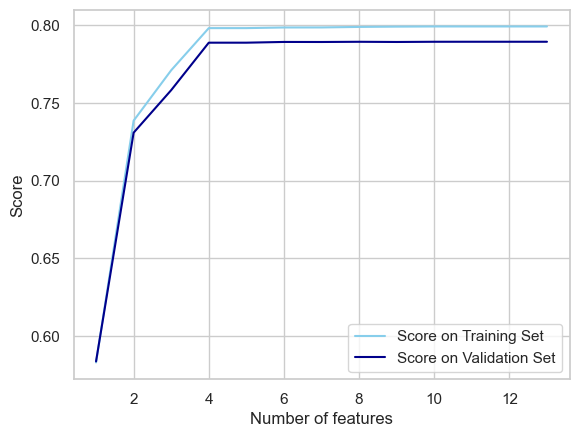

In [182]:
plt.plot(list(range(1,14)), train_score_list, label="Score on Training Set", color='skyblue')
plt.plot(list(range(1,14)), val_score_list, label="Score on Validation Set", color='darkblue')
plt.xlabel("Number of features")
plt.ylabel("Score")
plt.legend()
plt.show()

To maintain a balance between precision and complexity, we chose the number of features at which the score stabilizes: 4 features.

In [183]:
model = Lasso()
rfe = RFE(estimator = model, n_features_to_select = 4)
X_rfe = rfe.fit_transform(X = X_train_aux, y = y_train)
selected_features = pd.Series(rfe.support_, index = X_train_aux.columns)
selected_features

year                      True
mileage                   True
tax                      False
mpg                      False
engineSize                True
paintQuality%            False
previousOwners           False
hasDamage                False
carAge                   False
AvgUsage                 False
model_cleaned_encoded     True
Brand_model_encoded      False
Brand_cleaned_encoded    False
dtype: bool

### **Embendded Methods**

In [184]:
def plot_importance(coef,name):

    """
    Plots the feature importance as a horizontal bar chart.

    The function sorts the feature coefficients and visualizes them using a horizontal bar plot.
    This is used to show which features have the most influence on the target variable.

    Parameters
    ----------
    coef : pandas.Series
        A pandas Series containing the feature coefficients. The index should be the feature names.
    
    name : str
        Name of the model, used for the plot title.

    Returns
    -------
    None
        Displays a horizontal bar plot of feature importance.
    """

    imp_coef = coef.sort_values()
    plt.figure(figsize=(6,8))
    imp_coef.plot(kind = "barh", color='skyblue')
    plt.title("Feature importance using " + name + " Model")
    plt.show()

#### *LASSO*

Coefficients:
mileage                 -1853.711723
AvgUsage                 -363.669611
mpg                      -235.763289
tax                      -101.174958
carAge                    -15.720663
paintQuality%              -5.836768
hasDamage                  -0.000000
previousOwners              5.631351
Brand_cleaned_encoded     176.810597
Brand_model_encoded       491.241706
engineSize               2724.735813
year                     2731.347223
model_cleaned_encoded    4270.926648
dtype: float64

Eliminated variables: ['hasDamage']


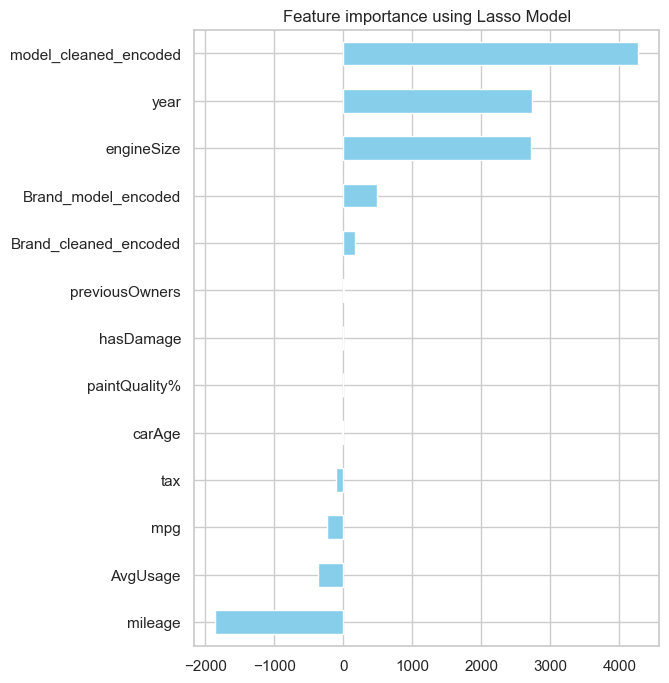

In [185]:
reg = LassoCV()
reg.fit(X_train_aux, y_train)
coef = pd.Series(reg.coef_, index = X_train_aux.columns)
print(f'Coefficients:\n{coef.sort_values()}\n')
print(f'Eliminated variables: {[feat for feat in coef.index if coef[feat]==0]}')
plot_importance(coef.sort_values(),'Lasso')

### **Final Insights**

<hr>

| Predictor | Variance | Spearman | RFE LR| RFE LASSO | Lasso | What to do? | 
| --- | --- | --- | --- | --- | --- | --- |
| year | Keep | Discard, perfectly correl with carAge | Keep |Keep | Keep | Discard
| mileage | Keep | Discard | Keep |Keep| Keep | Include in the model
| tax | Keep| Discard | Discard |Discard| Keep | Discard
| mpg | Keep | Discard | Discard | Discard | Keep | Discard
| engineSize | Keep | Keep? | Keep | Keep | Keep | Include in the model
| paintQuality | Keep | Discard | Discard | Discard | Keep | Discard
| previousOwners | Keep |Discard |Discard | Discard |  Keep | Discard
| hasDamage | Keep |Discard |Discard | Discard |  Discard | Discard
| carAge | Keep | Keep |Keep | Discard |  Keep | Include in the model
| AvgUsage | Keep |Keep? |Discard | Discard |  Keep | Include in the model
| Brand_cleaned_encoded | Keep | Discard |Discard | Discard |  Keep | Discard
| model_cleaned_encoded | Keep | Discard, perfectly correl with Brand_model |Keep | Keep |  Keep | Discard
| fuelType_cleaned_encoded | --- |--- |--- | --- |  --- | Include in the model
| transmission_cleaned_encoded | --- | --- |--- | --- |  --- | Include in the model
| Brand_model_encoded | Keep |Keep |Keep | Discard |  Keep | Include in the model

? means it is arguable

<hr>

In [186]:
X_train_scaled.drop(['year', 'tax', 'mpg', 'paintQuality%', 'previousOwners', 'hasDamage', 'Brand_cleaned_encoded' , 'model_cleaned_encoded'], axis=1, inplace=True)
X_val_scaled.drop(['year', 'tax', 'mpg', 'paintQuality%', 'previousOwners', 'hasDamage', 'Brand_cleaned_encoded' , 'model_cleaned_encoded'], axis=1, inplace=True)
df_test_scaled.drop(['year', 'tax', 'mpg', 'paintQuality%', 'previousOwners', 'hasDamage', 'Brand_cleaned_encoded' , 'model_cleaned_encoded'], axis=1, inplace=True)

X_train_scaled.head()

,mileage,engineSize,carAge,AvgUsage,Brand_model_encoded,fuelType_cleaned_ELECTRIC,fuelType_cleaned_HYBRID,fuelType_cleaned_OTHER,fuelType_cleaned_PETROL,transmission_cleaned_MANUAL,transmission_cleaned_OTHER,transmission_cleaned_SEMI-AUTO,transmission_cleaned_UNKNOWN
carID,,,,,,,,,,,,,
42904,0.336529,2.604060,0.048970,0.546568,1.559822,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
65965,-0.533377,0.661415,-0.936003,0.177663,0.646898,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
69226,-0.906242,0.272885,-0.443517,-0.986483,-0.023975,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36037,-0.846949,0.661415,-0.936003,-0.643368,2.179202,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1129,-1.049808,0.661415,-0.936003,-1.174519,0.952313,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


<h2 id="6th-bullet" style="background-color: #f7d888ff; color: #da6919ff; padding: 5px; margin: 5px;">
  <strong> 3. Modeling </strong>
</h2>

In [187]:
linear_regression = LinearRegression()
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=1.0, max_iter=10000)
elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000)
huber_model = HuberRegressor(epsilon=1.35, alpha = 0.0001, max_iter=100)

In [188]:
linear_regression.fit(X_train_scaled, y_train)
ridge_model.fit(X_train_scaled, y_train)
lasso_model.fit(X_train_scaled, y_train)
elastic_net_model.fit(X_train_scaled, y_train)
huber_model.fit(X_train_scaled, y_train)

HuberRegressor()

In [189]:
y_pred_linear_train = linear_regression.predict(X_train_scaled)
y_pred_linear_val = linear_regression.predict(X_val_scaled)
y_pred_ridge_train = ridge_model.predict(X_train_scaled)
y_pred_ridge_val = ridge_model.predict(X_val_scaled)
y_pred_lasso_train = lasso_model.predict(X_train_scaled)
y_pred_lasso_val = lasso_model.predict(X_val_scaled)
y_pred_elastic_net_train = elastic_net_model.predict(X_train_scaled)
y_pred_elastic_net_val = elastic_net_model.predict(X_val_scaled)
y_pred_huber_train = huber_model.predict(X_train_scaled)
y_pred_huber_val = huber_model.predict(X_val_scaled)

In [190]:
# Here we can compare the  predictions from the different models
real_vs_pred_val = pd.DataFrame({'y_true': y_val.values.flatten(), 'y_pred_linear': y_pred_linear_val.flatten(), 'y_pred_ridge': y_pred_ridge_val.flatten(), 'y_pred_lasso' : y_pred_lasso_val.flatten(), 'y_pred_elastic_net': y_pred_elastic_net_val.flatten(), 'y_pred_huber': y_pred_huber_val.flatten()}, 
                           index=y_val.index #ensures we can map the predictions to each observation correctly
                           )
real_vs_pred_val

,y_true,y_pred_linear,y_pred_ridge,y_pred_lasso,y_pred_elastic_net,y_pred_huber
carID,,,,,,
14278,29950,27048.430098,27048.646554,27050.023637,25943.240511,26354.471994
56641,10698,13846.907713,13846.862620,13845.051720,14304.761946,13367.437472
2172,16490,18356.973433,18356.702320,18348.199395,16942.035832,17878.264485
59953,9999,10182.778014,10183.194670,10193.387518,12368.613549,10432.411163
38177,36995,32876.886603,32877.167540,32885.298778,29835.803733,31763.656231
...,...,...,...,...,...,...
75427,14000,13209.173777,13209.117060,13208.778376,13853.731545,12585.596539
41842,9000,8658.119012,8658.482462,8657.713501,10733.582227,9074.456633
2104,11299,12776.773999,12776.377559,12770.943379,12543.779522,12170.919968


In [191]:
print(f"\nIntercept Linear Model: {linear_regression.intercept_:.2f}")
print(f"\nIntercept Ridge Model: {ridge_model.intercept_:.2f}")
print(f"\nIntercept Lasso Model: {lasso_model.intercept_:.2f}")
print(f"\nIntercept Elastic Net Model: {elastic_net_model.intercept_:.2f}")
print(f"\nIntercept Huber Model: {huber_model.intercept_:.2f}")


Intercept Linear Model: 16048.63

Intercept Ridge Model: 16049.42

Intercept Lasso Model: 16061.85

Intercept Elastic Net Model: 17255.91

Intercept Huber Model: 16089.26


In [192]:
linear_coefs = pd.DataFrame({'coef_linear': linear_regression.coef_, 'coef_ridge': ridge_model.coef_, 'coef_lasso': lasso_model.coef_, 'coef_elast': elastic_net_model.coef_, 'coef_huber': huber_model.coef_}, 
                           index=X_train_scaled.columns)
linear_coefs

,coef_linear,coef_ridge,coef_lasso,coef_elast,coef_huber
mileage,-1435.078052,-1435.215152,-1440.265377,-1440.287225,-260.916702
engineSize,3021.160141,3021.017113,3017.730678,2327.217360,2346.544635
carAge,-2847.295852,-2847.190801,-2844.367371,-2068.548572,-3188.433904
AvgUsage,-448.958364,-448.914707,-445.806023,-548.720630,-1255.141885
Brand_model_encoded,4737.771422,4737.585318,4736.959431,3286.155307,4429.503219
fuelType_cleaned_ELECTRIC,611.963203,488.936689,0.000000,-0.000000,1198.015449
fuelType_cleaned_HYBRID,1953.066840,1951.154355,1907.591483,58.220715,1638.370616
fuelType_cleaned_OTHER,2121.868742,2102.544421,1636.641391,2.804492,1684.510497
fuelType_cleaned_PETROL,2259.756531,2259.103070,2245.116717,75.440318,1385.034853
transmission_cleaned_MANUAL,-1144.666950,-1145.121952,-1147.920469,-1046.570247,-1175.124307


In [193]:
def adjusted_r2 (r2,n,p):

    """
    Calculates the adjusted R-squared for a regression model. Adjusted R-squared adjusts the standard R-squared value based on the number of predictors 
    in the model, penalizing for including variables that do not improve the model fit.

    Parameters
    ----------
    r2 : float
        The R-squared value of the model.
    
    n : int
        The number of observations in the dataset.
    
    p : int
        The number of predictors/features in the model.

    Returns
    -------
    float
        The adjusted R-squared value.
    """

    return 1-(1-r2)*(n-1)/(n-p-1)

In [194]:
n_train = len(y_train)
p_train = len(X_train_scaled.columns)

n_val = len(y_val)
p_val = len(X_val_scaled.columns)

In [195]:
# Create comparison dataframe
comparison_models = pd.DataFrame({
    'Model': ['OLS', 'Ridge', 'Lasso', 'Elastic net', 'Huber Regressor'],
    'Train R²': [
        r2_score(y_train, y_pred_linear_train),
        r2_score(y_train, y_pred_ridge_train),
        r2_score(y_train, y_pred_lasso_train),
        r2_score(y_train, y_pred_elastic_net_train),
        r2_score(y_train, y_pred_huber_train)
    ],
    'Val R²': [
        r2_score(y_val, y_pred_linear_val),
        r2_score(y_val, y_pred_ridge_val),
        r2_score(y_val, y_pred_lasso_val),
        r2_score(y_val, y_pred_elastic_net_val),
        r2_score(y_val, y_pred_huber_val)
    ],
    'Train Adjusted R²': [
        adjusted_r2(r2_score(y_train, y_pred_linear_train), n_train, p_train),
        adjusted_r2(r2_score(y_train, y_pred_ridge_train), n_train, p_train),
        adjusted_r2(r2_score(y_train, y_pred_lasso_train), n_train, p_train),
        adjusted_r2(r2_score(y_train, y_pred_elastic_net_train), n_train, p_train),
        adjusted_r2(r2_score(y_train, y_pred_huber_train), n_train, p_train)
    ],
    'Val Adjusted R²': [
        adjusted_r2(r2_score(y_val, y_pred_linear_val), n_val, p_val),
        adjusted_r2(r2_score(y_val, y_pred_ridge_val), n_val, p_val),
        adjusted_r2(r2_score(y_val, y_pred_lasso_val), n_val, p_val),
        adjusted_r2(r2_score(y_val, y_pred_elastic_net_val), n_val, p_val),
        adjusted_r2(r2_score(y_val, y_pred_huber_val), n_val, p_val)
    ],
    'Train MAE': [
        mean_absolute_error(y_train, y_pred_linear_train),
        mean_absolute_error(y_train, y_pred_ridge_train),
        mean_absolute_error(y_train, y_pred_lasso_train),
        mean_absolute_error(y_train, y_pred_elastic_net_train),
        mean_absolute_error(y_train, y_pred_huber_train)
    ],
    'Val MAE': [
        mean_absolute_error(y_val, y_pred_linear_val),
        mean_absolute_error(y_val, y_pred_ridge_val),
        mean_absolute_error(y_val, y_pred_lasso_val),
        mean_absolute_error(y_val, y_pred_elastic_net_val),
        mean_absolute_error(y_val, y_pred_huber_val)
    ],
    'Train RMSE': [
        root_mean_squared_error(y_train, y_pred_linear_train),
        root_mean_squared_error(y_train, y_pred_ridge_train),
        root_mean_squared_error(y_train, y_pred_lasso_train),
        root_mean_squared_error(y_train, y_pred_elastic_net_train),
        root_mean_squared_error(y_train, y_pred_huber_train)
    ],
    'Val RMSE': [
        root_mean_squared_error(y_val, y_pred_linear_val),
        root_mean_squared_error(y_val, y_pred_ridge_val),
        root_mean_squared_error(y_val, y_pred_lasso_val),
        root_mean_squared_error(y_val, y_pred_elastic_net_val),
        root_mean_squared_error(y_val, y_pred_huber_val)
    ],
    'Train MedAE': [
        median_absolute_error(y_train, y_pred_linear_train),
        median_absolute_error(y_train, y_pred_ridge_train),
        median_absolute_error(y_train, y_pred_lasso_train),
        median_absolute_error(y_train, y_pred_elastic_net_train),
        median_absolute_error(y_train, y_pred_huber_train)
    ],
    'Val MedAE': [
        median_absolute_error(y_val, y_pred_linear_val),
        median_absolute_error(y_val, y_pred_ridge_val),
        median_absolute_error(y_val, y_pred_lasso_val),
        median_absolute_error(y_val, y_pred_elastic_net_val),
        median_absolute_error(y_val, y_pred_huber_val)
    ],
    'Train MAPE': [
        mean_absolute_percentage_error(y_train, y_pred_linear_train),
        mean_absolute_percentage_error(y_train, y_pred_ridge_train),
        mean_absolute_percentage_error(y_train, y_pred_lasso_train),
        mean_absolute_percentage_error(y_train, y_pred_elastic_net_train),
        mean_absolute_percentage_error(y_train, y_pred_huber_train)
    ],
    'Val MAPE': [
        mean_absolute_percentage_error(y_val, y_pred_linear_val),
        mean_absolute_percentage_error(y_val, y_pred_ridge_val),
        mean_absolute_percentage_error(y_val, y_pred_lasso_val),
        mean_absolute_percentage_error(y_val, y_pred_elastic_net_val),
        mean_absolute_percentage_error(y_val, y_pred_huber_val)
    ],
})

print("Model Comparison:")
comparison_models

Model Comparison:


,Model,Train R²,Val R²,Train Adjusted R²,Val Adjusted R²,Train MAE,Val MAE,Train RMSE,Val RMSE,Train MedAE,Val MedAE,Train MAPE,Val MAPE
0,OLS,0.811997,0.801897,0.811951,0.801784,2595.393613,2659.646218,4172.887862,4448.699611,1852.753248,1842.236247,0.188100,0.190922
1,Ridge,0.811997,0.801896,0.811951,0.801783,2595.377914,2659.631727,4172.888104,4448.710738,1852.641718,1842.658306,0.188098,0.190919
2,Lasso,0.811989,0.801875,0.811943,0.801762,2595.123619,2659.498997,4172.970344,4448.948414,1852.630704,1841.271997,0.188072,0.190899
3,Elastic net,0.767051,0.752932,0.766994,0.752791,2789.498167,2855.998845,4644.990838,4968.166975,1976.222991,1975.992893,0.182405,0.183846
4,Huber Regressor,0.800855,0.789145,0.800807,0.789025,2502.081396,2569.759600,4294.755945,4589.649251,1686.246365,1690.160582,0.168219,0.170810


The higher the R2 the better the model fits the data. It measures the amount of variance in the target that can be explained by the model. It always increases with the number of independent variables so I compute the adjusted R2 to confirm that we are not putting too many features in the model. For the following metrics, the closer to 0.0 the better.

Now to explain the how distance our prediction is from the true value we will use MAE, its a good metric and it is also the metric that will be used to evaluate the results in the kaggle competition. The best possible value is 0.0. Measures Errors in an Uniform Manner: Useful in problems where the magnitude of the error is not particularly relevant (although this particular point  is a disadvantage when magnitude is relevant). Since our goal is to predict car prices the magnitude of the error is a big factor, it is very differnt to predict a price of 2000 and 20000. 

For interpretability purposes and because it is easily communicated to stakeholders, we will also compute MAPE. One of the disadvantages of this metric is that when actual values are close to zero, even small absolute errors can result in very large percentage errors, but in the train data set at least, the minimum value of the target is 450, so we will not encounter this problem.

To adress the problem with MAE we will also compute RSME, however we need to consider that this metric is very sensitive to outliers and that it lacks interpretabibilty

When ploting the distribuition of the errors, if it is skewed or contains extreme values we should use Median Absolute Error. Its very useful also in the presence of outliers which is the case of this data set.

In [196]:
residuals_linear = y_val - y_pred_linear_val
residuals_ridge = y_val - y_pred_ridge_val
residuals_lasso = y_val - y_pred_lasso_val
residuals_elastic_net = y_val - y_pred_elastic_net_val
residuals_huber = y_val - y_pred_huber_val

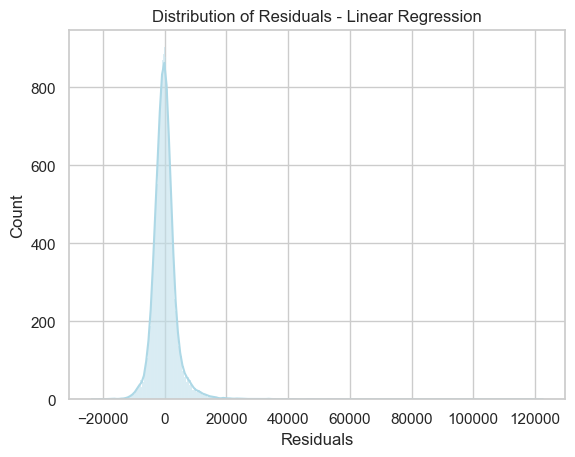

In [197]:
sns.set_style("whitegrid")
sns.histplot(residuals_linear, kde=True, color="lightblue")
plt.xlabel("Residuals")
plt.title("Distribution of Residuals - Linear Regression")
plt.show()

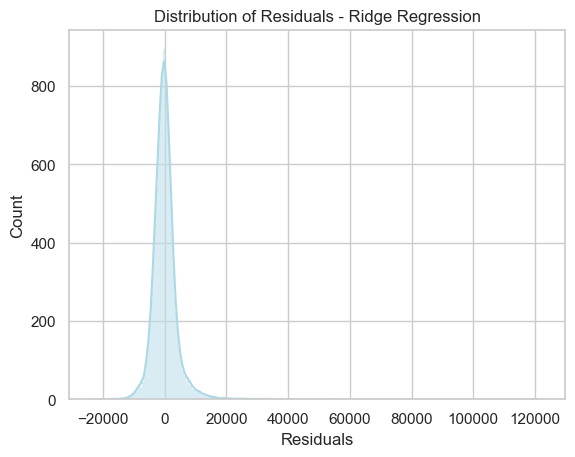

In [198]:
sns.histplot(residuals_ridge, kde=True, color="lightblue")
plt.xlabel("Residuals")
plt.title("Distribution of Residuals - Ridge Regression")
plt.show()

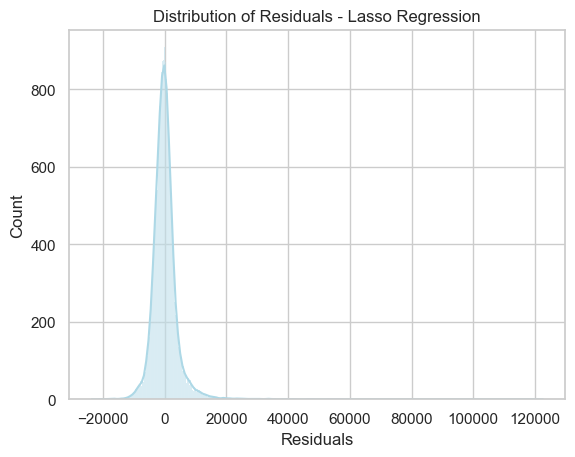

In [199]:
sns.histplot(residuals_lasso, kde=True, color="lightblue")
plt.xlabel("Residuals")
plt.title("Distribution of Residuals - Lasso Regression")
plt.show()

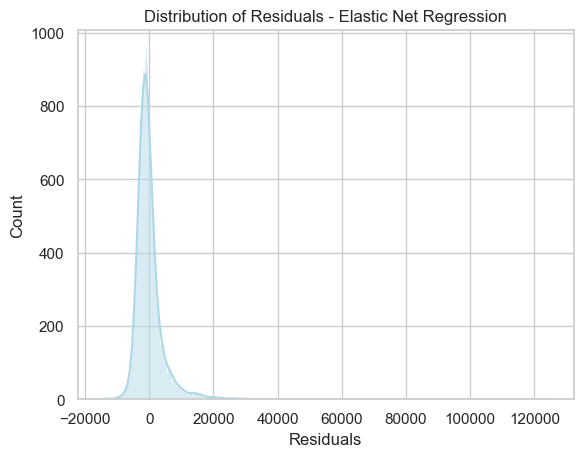

In [200]:
sns.histplot(residuals_elastic_net, kde=True, color="lightblue")
plt.xlabel("Residuals")
plt.title("Distribution of Residuals - Elastic Net Regression")
plt.show()

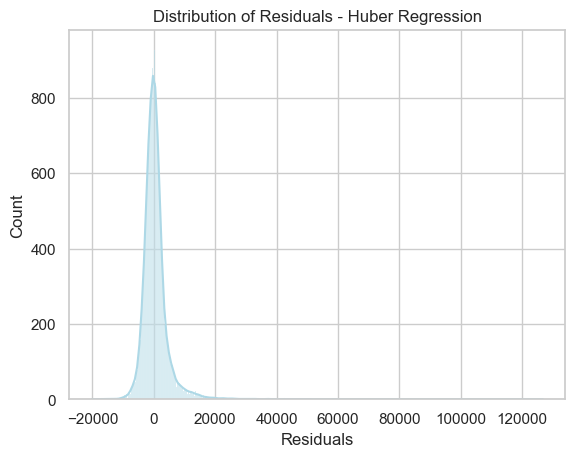

In [201]:
sns.histplot(residuals_huber, kde=True, color="lightblue")
plt.xlabel("Residuals")
plt.title("Distribution of Residuals - Huber Regression")
plt.show()

Centered around 0 → means the model’s predictions are unbiased (it doesn’t systematically over- or under-estimate)

Roughly symmetric and bell-shaped → suggests residuals are approximately normally distributed, which is ideal for linear regression assumptions.

Slight tail on the right (positive side) → indicates a few large positive errors — the model occasionally underestimates high prices (typical in price prediction problems).

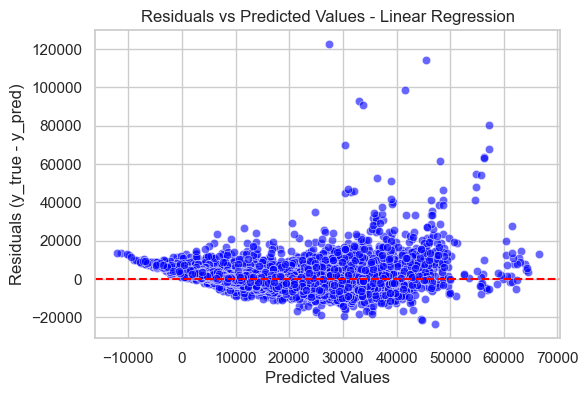

In [202]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_linear_val, y=residuals_linear, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (y_true - y_pred)")
plt.title("Residuals vs Predicted Values - Linear Regression")
plt.show()

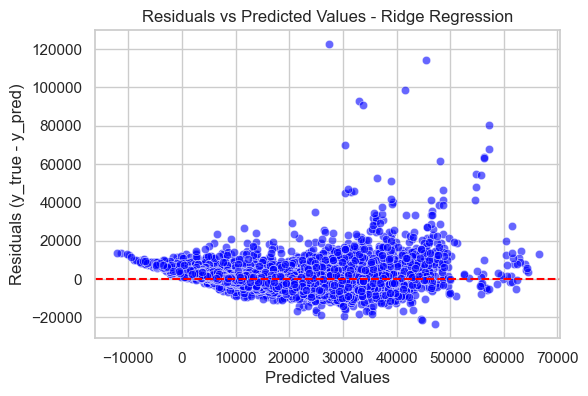

In [203]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_ridge_val, y=residuals_ridge, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (y_true - y_pred)")
plt.title("Residuals vs Predicted Values - Ridge Regression")
plt.show()

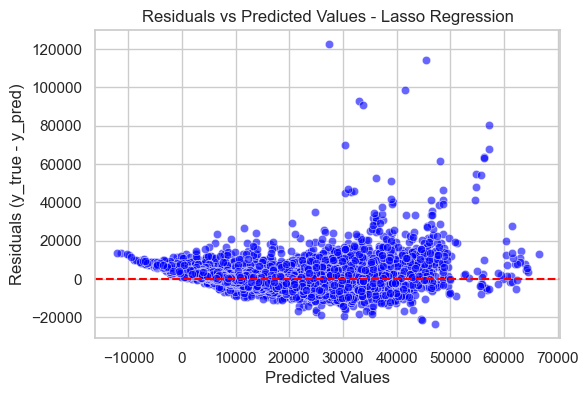

In [204]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_lasso_val, y=residuals_lasso, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (y_true - y_pred)")
plt.title("Residuals vs Predicted Values - Lasso Regression")
plt.show()

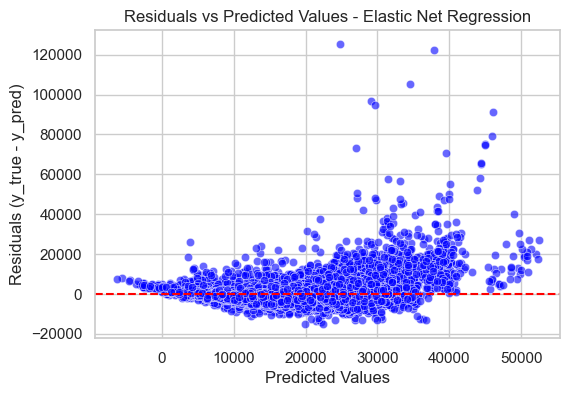

In [205]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_elastic_net_val, y=residuals_elastic_net, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (y_true - y_pred)")
plt.title("Residuals vs Predicted Values - Elastic Net Regression")
plt.show()

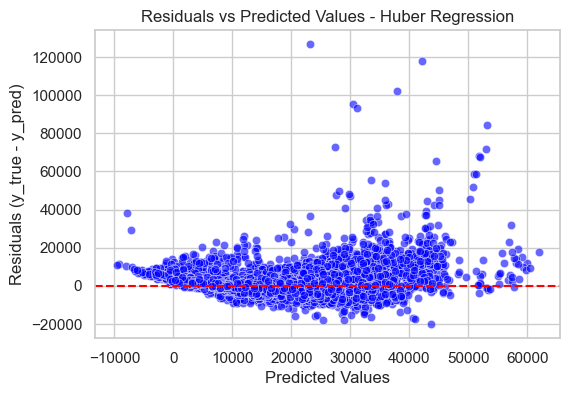

In [206]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_huber_val, y=residuals_huber, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (y_true - y_pred)")
plt.title("Residuals vs Predicted Values - Huber Regression")
plt.show()

<h2 id="7th-bullet" style="background-color: #f7d888ff; color: #da6919ff; padding: 5px; margin: 5px;">
  <strong> 4. Deployment </strong>
</h2>

In [207]:
final_model = huber_model
y_test = pd.DataFrame(final_model.predict(df_test_scaled), index=df_test_scaled.index, columns=['price'])
y_test

,price
carID,
89856,13293.238441
106581,22365.148376
80886,15995.938369
100174,18410.010135
81376,21314.513959
...,...
105775,17275.992812
81363,32098.899427
76833,29925.785902


In [208]:
y_test.to_csv("huber_predictions.csv")